### Imports

In [1]:
import numpy as np
import pandas as pd
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import seaborn as sns

import metabolinks as mtl
import metabolinks.transformations as transf
from metabolinks.similarity import mz_similarity

import scaling as sca
import multianalysis as ma

In [2]:
%matplotlib inline

### Similarity analysis without CHT, CFN and SB samples.

### Peak alignments analysed: 
#### 1 - 1st alignment: min_sample = 2, 2nd alignment: min_sample = 1 - NAME: 2-1 / Original
#### 2 - 1st alignment: min_sample = 3, 2nd alignment: min_sample = 3 - NAME: 3-3

To better understand the functions used outside of normal Python packages, see scaling.py and multianalysis.py where they are better described and try tosay what is happening in each block of code.

In [3]:
def read_aligned_files(filename):
    """Short function to read the aligned files fast while putting the MultiIndex in the correct order for the CDL accessor."""
    df = pd.read_csv(filename, header = None, index_col = [0])
    df.index.name = 'm/z'
    mi = pd.concat([df.iloc[1, :],df.iloc[0, :]], axis = 'columns')
    mi = pd.MultiIndex.from_frame(mi)
    final_file = pd.read_csv(filename, header = [0,1], index_col = [0])
    final_file.columns = mi
    return final_file

## Similarity analysis
aligned_all_neg = negative dataset alignment 2-1 (Original) / aligned_neg - binary matrix equivalent

aligned_all_pos = positive dataset alignment 2-1 (Original) / aligned_pos - binary matrix equivalent

aligned_all_neg2 = negative dataset alignment 3-3 / aligned_neg2 - binary matrix equivalent

aligned_all_pos2 = positive dataset alignment 3-3 / aligned_pos2 - binary matrix equivalent

### Read aligned data of the 1st alignment 2-1 - Analysis of this one first

In [4]:
aligned_all_pos = pd.HDFStore('alignments_new.h5').get('groups_1ppm_min2_all_1ppm_pos')
aligned_all_neg = pd.HDFStore('alignments_new.h5').get('groups_1ppm_min2_all_1ppm_neg')

### Compute m/z similarities - Not present in yeast_new (maybe take out in future versions except first cell)

In [5]:
sim_pos = mz_similarity(aligned_all_pos, has_labels = True)
sim_neg = mz_similarity(aligned_all_neg, has_labels = True)

In [6]:
print(sim_pos)


Sample similarity, counts of common peaks
     14   15   16   29   30   31    8    9   10    23  ...   22    35    36  \
14  342  296  269  236  235  231  234  240  237   204  ...  141   221   222   
15  296  386  313  263  256  254  244  252  249   230  ...  149   246   248   
16  269  313  359  251  247  248  237  241  239   219  ...  155   237   239   
29  236  263  251  672  523  545  258  263  270   368  ...  161   445   444   
30  235  256  247  523  616  489  260  267  268   352  ...  164   420   419   
31  231  254  248  545  489  638  259  268  281   357  ...  163   450   445   
8   234  244  237  258  260  259  487  408  378   232  ...  149   258   261   
9   240  252  241  263  267  268  408  512  403   235  ...  151   272   273   
10  237  249  239  270  268  281  378  403  482   243  ...  150   285   287   
23  204  230  219  368  352  357  232  235  243  1495  ...  141   596   597   
24  198  224  212  367  352  359  235  240  249  1280  ...  139   623   618   
25  190  

In [7]:
print(sim_neg)


Sample similarity, counts of common peaks
     14   15   16   29   30   31    8    9   10   23  ...   22   35   36   37  \
14  444  307  334  245  241  223  205  217  217  110  ...  163  157  160  171   
15  307  338  228  151  147  135  175  187  188   37  ...  145  151  151  162   
16  334  228  365  220  216  198  188  204  198  109  ...  115  140  142  153   
29  245  151  220  674  647  589  175  181  177  149  ...  131  187  217  218   
30  241  147  216  647  687  602  173  178  174  151  ...  131  191  224  225   
31  223  135  198  589  602  629  158  163  160  151  ...  125  176  201  201   
8   205  175  188  175  173  158  377  338  348   62  ...  130  220  143  230   
9   217  187  204  181  178  163  338  402  373   64  ...  136  215  148  226   
10  217  188  198  177  174  160  348  373  412   64  ...  133  222  144  234   
23  110   37  109  149  151  151   62   64   64  351  ...   44   38   36   37   
24  123   45  120  161  164  163   73   74   73  319  ...   55   4

### Clustermap peak list function

In [8]:
def clustermap_peak_list(aligned):
    aligned_01 = aligned.copy()
    aligned_01[aligned_01.notnull()] = 1
    aligned_01[aligned_01.isnull()] = 0
    aligned_01.columns = aligned_01.cdl.samples

    ulabels = aligned.cdl.unique_labels
    n = len(ulabels)
    
    p = sns.color_palette() + sns.color_palette("Set1", n_colors=n-10, desat=.5)
    sample_to_labels = pd.Series(aligned.cdl.labels, index=aligned.cdl.samples)
    label_colors = pd.Series(p, index=ulabels)
    sample_colors = sample_to_labels.map(label_colors)
    
    g = sns.clustermap(aligned_01, metric="jaccard", figsize=(15, 20), 
                       row_cluster=False,
                       col_colors=sample_colors,
                       yticklabels=False)
    # fix bug in seaborn, error in clustermap if cbar == False
    ax=g.cax; aax=ax.clear(); aax = ax.axis('off'); 

    # draw legend
    lpatches = [mpatches.Patch(color=c, label=lbl) for (lbl, c) in label_colors.iteritems()]
    leg = plt.legend(handles=lpatches, fontsize=20)
    return g
    

Sample HC, NEGATIVE mode


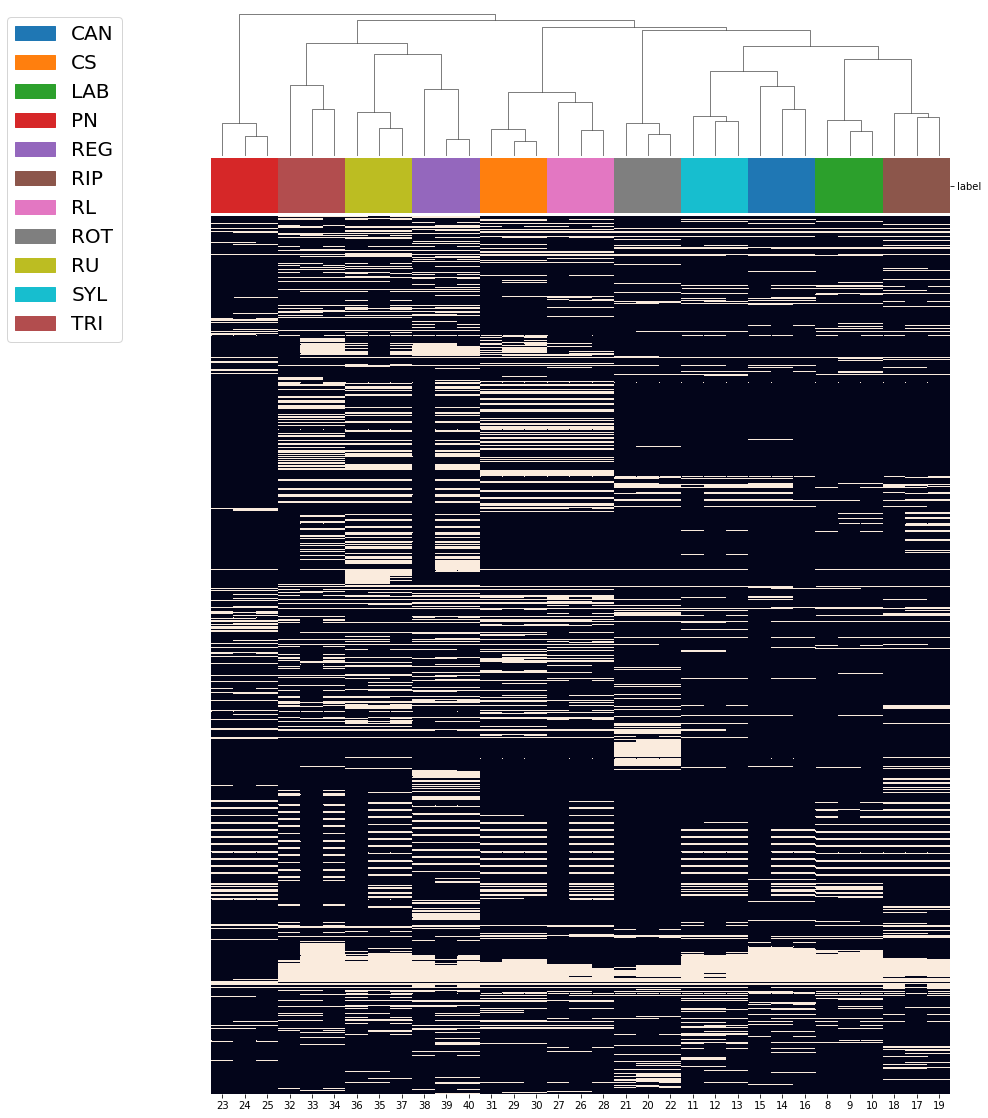

In [9]:
print('Sample HC, NEGATIVE mode')
g = clustermap_peak_list(aligned_all_neg)

Sample HC, POSITIVE mode


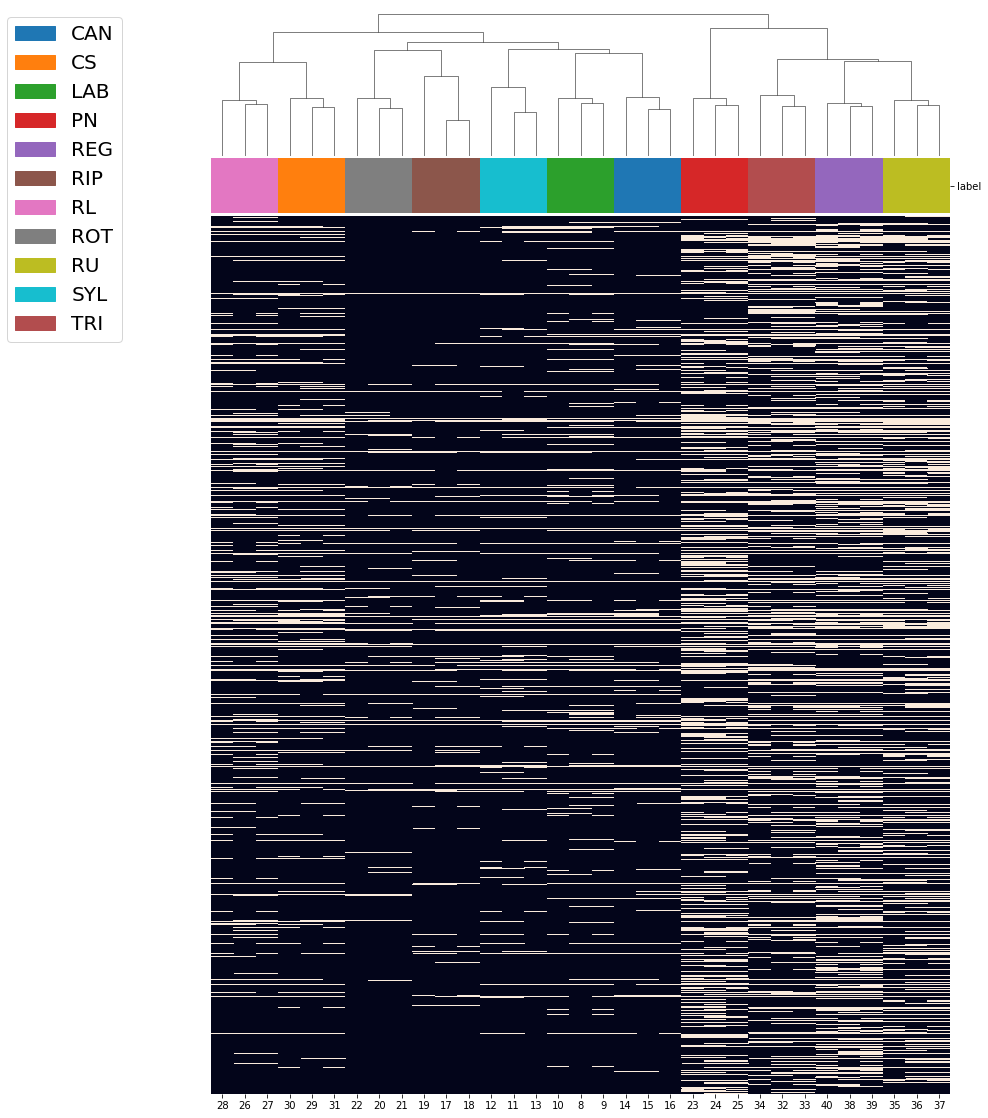

In [10]:
print('Sample HC, POSITIVE mode')
g = clustermap_peak_list(aligned_all_pos)

### Global metadata for consistency between tables and plots

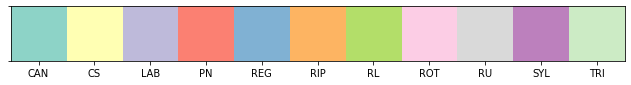

In [11]:
sample_names = aligned_all_neg.cdl.samples
all_labels = aligned_all_neg.cdl.labels
unique_labels = aligned_all_neg.cdl.unique_labels

# customize these colors
colours = sns.color_palette('Set3', 11)

label_colors = {lbl: c for lbl, c in zip(unique_labels, colours)}

sns.palplot(label_colors.values())
new_ticks = plt.xticks(range(len(unique_labels)), unique_labels)

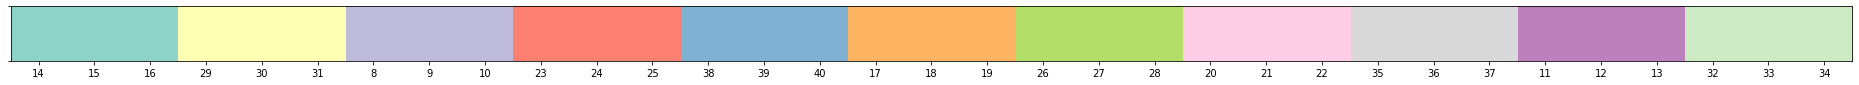

In [12]:
sample_colors = {s: label_colors[lbl] for s, lbl in zip(sample_names, all_labels)}

sns.palplot(sample_colors.values())
new_ticks = plt.xticks(range(len(sample_names)), sample_names)

## Data transformations

### Each Dataset is transformed to binary or ...

3/4 types of processing are made:

(Imp (Ionly) - Only Missing Value Imputation).

P - Missing Value Imputation and Pareto Scaling.

NP - Missing Value Imputation, Normalization by reference feature and Pareto Scaling.

NGP - Missing Value Imputation, Normalization by reference feature, glog transformation and Pareto Scaling.

In [13]:
def df_to_bool(df):
    "Transforms data into 'binary' matrices."
    return df.mask(df.notnull(), 1).mask(df.isnull(), 0)

def compute_transf(dataset, norm_ref=None, lamb=None):
    intensities = dataset
    dicto = {}
    
    imputed = transf.fillna_frac_min(intensities, fraction=0.5)
    if norm_ref is not None:
        norm = transf.normalize_ref_feature(imputed, norm_ref, remove=True)
    else:
        norm = imputed
    P = transf.pareto_scale(imputed)
    NP = transf.pareto_scale(norm)
    NGP = transf.pareto_scale(transf.glog(norm, lamb=lamb))
    
    dicto['binary'] = df_to_bool(intensities)
    dicto['Ionly'] = imputed
    dicto['P'] = P
    dicto['NP'] = NP
    dicto['NGP'] = NGP
    
    return dicto

In [14]:
#Theoretical mass for negative mode Leucine Enkephalin - 554.2615.
RefEst_Neg = sca.search_for_ref_feat(aligned_all_neg, 554.2615) #see if the function gives the reference feature
print(RefEst_Neg) #It did!

#Theoretical mass for positive mode Leucine Enkephalin - 556.2771.
RefEst_Pos = sca.search_for_ref_feat(aligned_all_pos, 556.2771)
print(RefEst_Pos)

(554.26202, 0.0005200000000513683)
(556.27657, 0.0005300000000261207)


In [15]:
# Negative mode dataset
treat_neg = compute_transf(aligned_all_neg, norm_ref = 554.26202)

# Positive mode dataset
treat_pos = compute_transf(aligned_all_pos, norm_ref = 556.2765711904763)

## Similarity analysis (Jaccard)

In [16]:
def plot_jaccard_sims(dataset, title=''):
    intensities = dataset
    sims = mz_similarity(intensities, has_labels=True)
    #grid_kws = {"height_ratios": (0.4, 0.4, 0.02)}
    f, ax = plt.subplots(1,2, figsize=(14, 7), constrained_layout=True) # gridspec_kw=grid_kws,

    hm = sns.heatmap(sims.sample_similarity_jaccard, annot=False, square=True, ax=ax[0], cmap='YlGnBu', cbar=None)
    hm = sns.heatmap(sims.label_similarity_jaccard, annot=True, square=True, ax=ax[1], cmap='YlGnBu')
    
    #Correction for heatmap bug in latest version of seaborn
    bottom, top = ax[0].get_ylim()
    ax[0].set_ylim(bottom + 0.5, top - 0.5)
    bottom, top = ax[1].get_ylim()
    ax[1].set_ylim(bottom + 0.5, top - 0.5)
    
    ax[0].set_title('Sample similarity')
    ax[1].set_title('Group similarity')
    f.suptitle(title, fontsize=16)

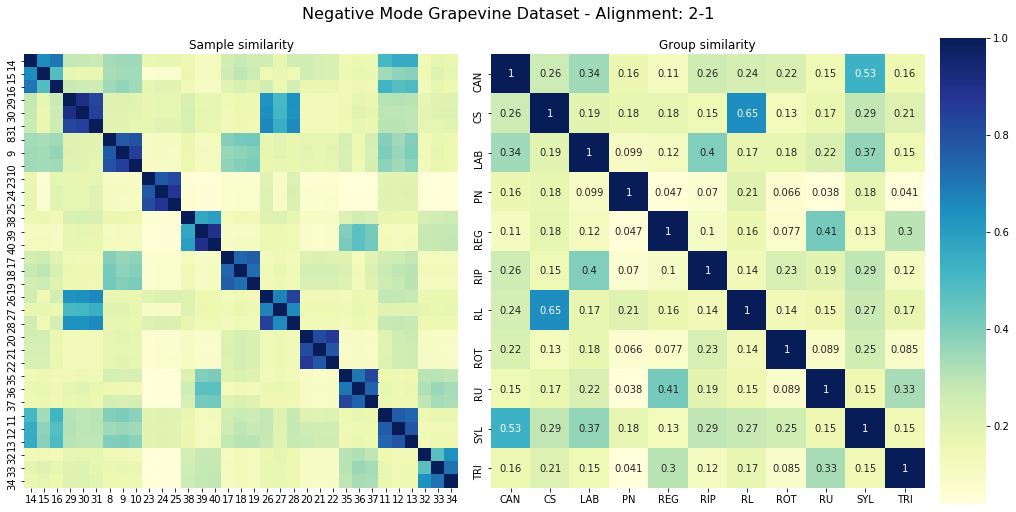

In [17]:
plot_jaccard_sims(aligned_all_neg, 'Negative Mode Grapevine Dataset - Alignment: 2-1')

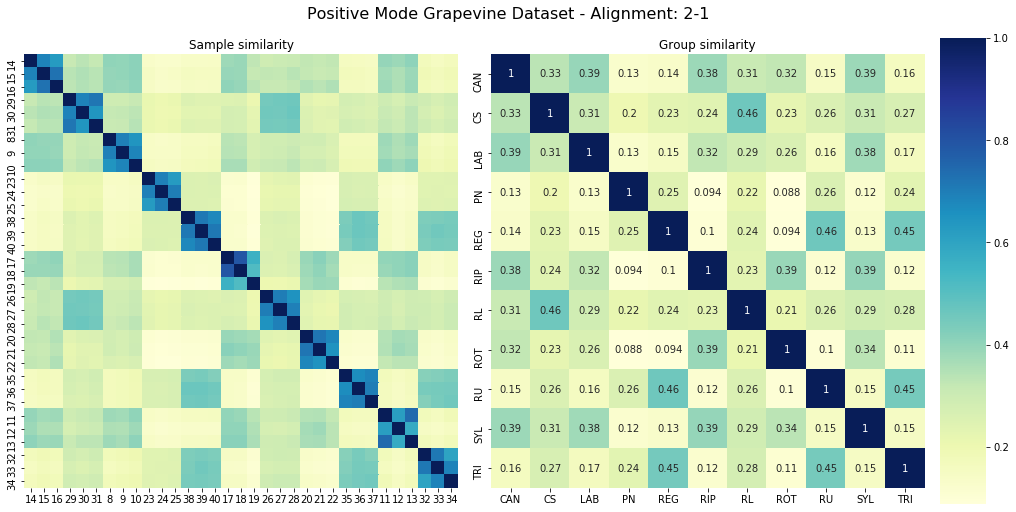

In [18]:
plot_jaccard_sims(aligned_all_pos, 'Positive Mode Grapevine Dataset - Alignment: 2-1')

#### Verification that `dist.pdist()` produces the same result as `mz_similarity()`

In [19]:
intensities = aligned_all_neg
neg_01 = treat_neg['binary']

scipy_jdist = dist.pdist(neg_01.T, metric='jaccard')
df_scipy_dist = pd.DataFrame(dist.squareform(scipy_jdist), index=sample_names, columns=sample_names)

#sim_neg = mz_similarity(intensities, has_labels=True)
jsim = sim_neg.sample_similarity_jaccard
#jsim.index.name = 'Sample'
#jsim.columns.name = 'Sample'
jdist = 1 - jsim

from pandas.testing import assert_frame_equal
assert_frame_equal(jdist, df_scipy_dist)
# No exception should be raised!

Dendogram from Jaccard distance, Negative mode Grapevine dataset - Alignment: 2-1 (cophenetic = 0.91674)


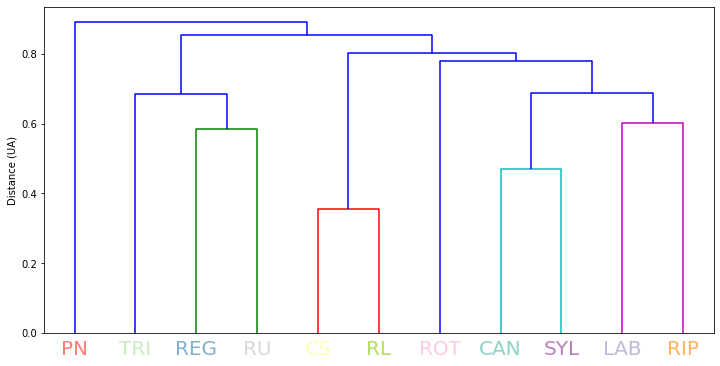

In [20]:
jdist = dist.squareform(1 - sim_neg.label_similarity_jaccard.values)
Z = hier.linkage(jdist, method='average')

coph = hier.cophenet(Z,jdist)[0]
print(f'Dendogram from Jaccard distance, Negative mode Grapevine dataset - Alignment: 2-1 (cophenetic = {coph:.5f})')

fig = plt.figure(figsize=(12,6))
dn = hier.dendrogram(Z, labels=unique_labels, leaf_font_size=20, above_threshold_color='b')

#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

Dendogram from Jaccard distance, Positive mode Grapevine dataset - Alignment: 2-1 (cophenetic = 0.89821)


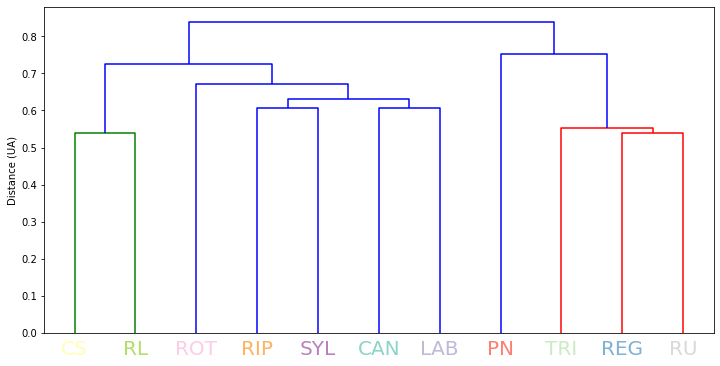

In [21]:
jdist = dist.squareform(1 - sim_pos.label_similarity_jaccard.values)
Z = hier.linkage(jdist, method='average')

coph = hier.cophenet(Z,jdist)[0]
print(f'Dendogram from Jaccard distance, Positive mode Grapevine dataset - Alignment: 2-1 (cophenetic = {coph:.5f})')

fig = plt.figure(figsize=(12,6))
dn = hier.dendrogram(Z, labels=unique_labels, leaf_font_size=20, above_threshold_color='b')

#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

## Hierarchical Cluster Analysis (agglomerative)


### Non-binary Similarity Analysis

All samples need to have missing value imputation (removing features is optional) with the function NaN_Imputation of scaling.py (replace missing features with half of the minimum intensity of the full dataset).

After that, the rest of the data processing can vary where 3 different processing methods were applied in different combinations:

##### Normalization by a references feature (Norm_feat from scaling.py) - N;
##### Glog transformation/ log2 transformation (glog from scaling.py) - G;
##### Pareto Scaling (ParetoScal from scaling.py) - P.

In [22]:
def plot_dendogram(Z, title=''):
    fig = plt.figure(figsize=(16,6))
    dn = hier.dendrogram(Z, labels=all_labels, leaf_font_size=15, above_threshold_color='b')
    #Coloring labels
    ax = plt.gca()
    ax.set_ylabel('Distance (UA)')
    ax.set_title(title, fontsize = 13)
    xlbls = ax.get_xmajorticklabels()
    for lbl in xlbls:
        lbl.set_color(label_colors[lbl.get_text()])

### Negative Mode - 2-1 Bias Alignment - Dendograms with each differently-treated Grapevine Dataset

Each feature appears at least in 2 samples of the 3 replicates in any of the grapevine varieties. 2_1 in figures.

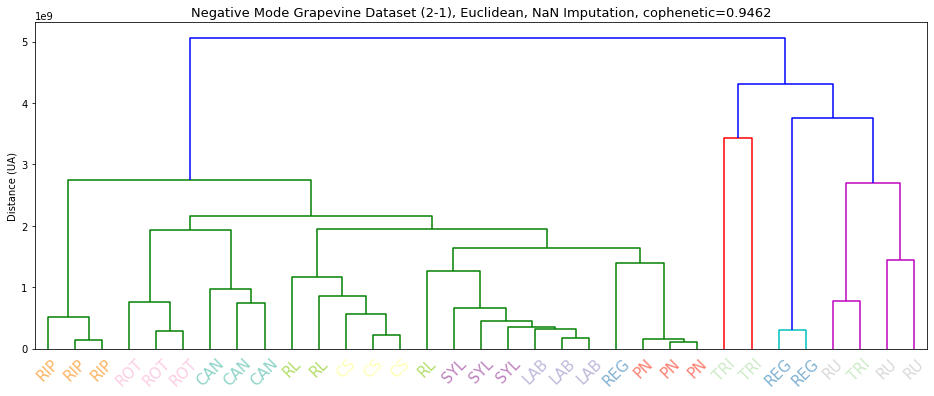

In [23]:
# Missing Value Imputation only
Imp_neg = treat_neg['Ionly']
dist_Imp_neg = dist.pdist(Imp_neg.T, metric = 'euclidean')
Z_Imp_neg = hier.linkage(dist_Imp_neg, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_Imp_neg, dist_Imp_neg)[0]

title = f'Negative Mode Grapevine Dataset (2-1), Euclidean, NaN Imputation, cophenetic={coph:.4f}'
plot_dendogram(Z_Imp_neg, title)

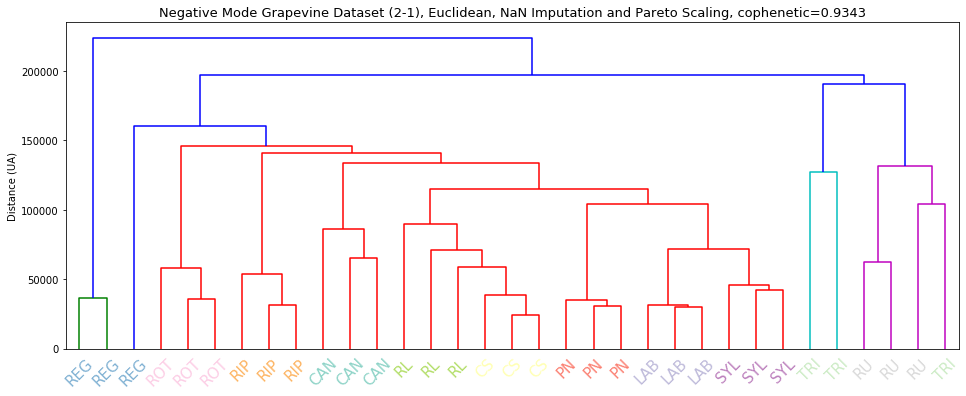

In [24]:
# Imputed and Pareto scaled
P_neg = treat_neg['P']
dist_P_neg = dist.pdist(P_neg.T, metric = 'euclidean')
Z_P_neg = hier.linkage(dist_P_neg, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_neg, dist_P_neg)[0] #method average seems to lead to higher coefficients
title = f'Negative Mode Grapevine Dataset (2-1), Euclidean, NaN Imputation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_P_neg, title)

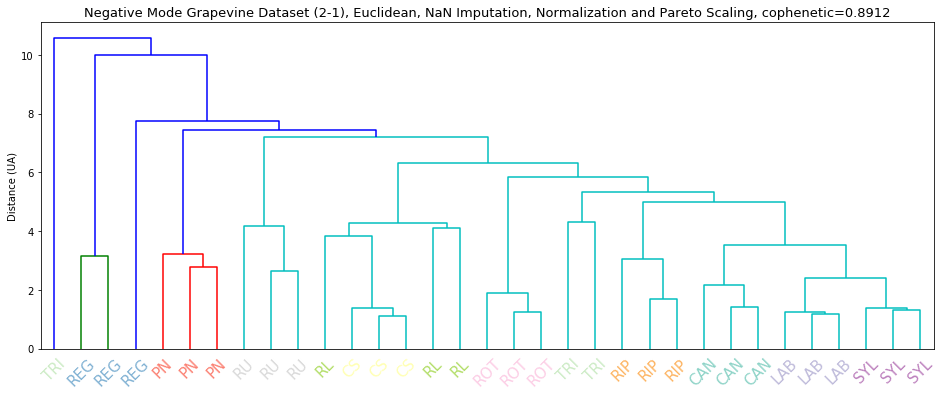

In [25]:
# Imputed, Normalized (reference feature) and Pareto scaled
NP_neg = treat_neg['NP']
dist_NP_neg = dist.pdist(NP_neg.T, metric = 'euclidean')
Z_NP_neg = hier.linkage(dist_NP_neg, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NP_neg, dist_NP_neg)[0] #method average seems to lead to higher coefficients
title = f'Negative Mode Grapevine Dataset (2-1), Euclidean, NaN Imputation, Normalization and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NP_neg, title)

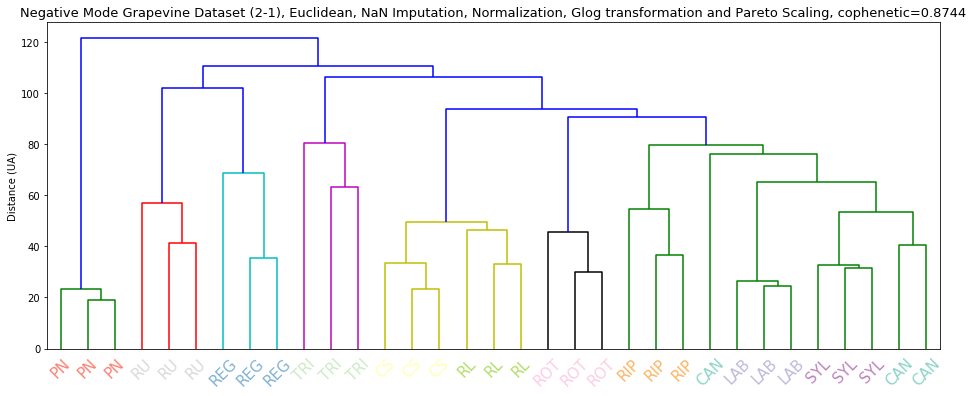

In [26]:
# Imputed, Normalized (reference feature), glog transformed and Pareto scaled
NGP_neg = treat_neg['NGP']
dist_NGP_neg = dist.pdist(NGP_neg.T, metric = 'euclidean')
Z_NGP_neg = hier.linkage(dist_NGP_neg, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_neg, dist_NGP_neg)[0] #method average seems to lead to higher coefficients
title = f'Negative Mode Grapevine Dataset (2-1), Euclidean, NaN Imputation, Normalization, Glog transformation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NGP_neg, title)

#### Binary Similarity Analysis Methods - Example Dendogram

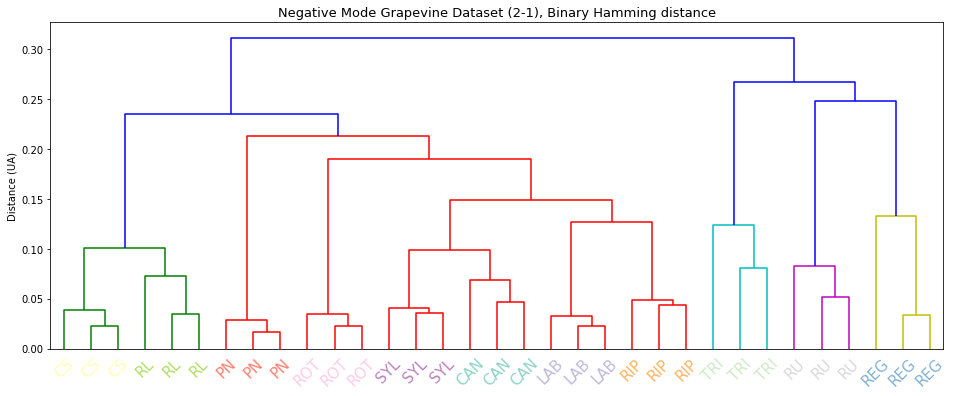

In [27]:
binary = treat_neg['binary']

#Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# print('Yeast dendrogram, Binary methods, Normalized by MetScape')
Zdice = hier.linkage(binary.T, metric='hamming', method='average')

title = f'Negative Mode Grapevine Dataset (2-1), Binary Hamming distance'
plot_dendogram(Zdice, title)

### Positive Mode - 2-1 Bias Alignment - Dendograms with each differently-treated Grapevine Dataset

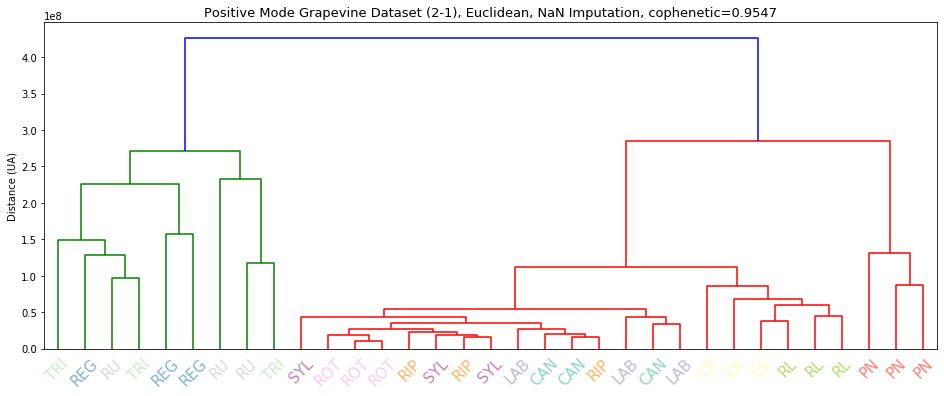

In [28]:
# Missing Value Imputation only
Imp_pos = treat_pos['Ionly']
dist_Imp_pos = dist.pdist(Imp_pos.T, metric = 'euclidean')
Z_Imp_pos = hier.linkage(dist_Imp_pos, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_Imp_pos, dist_Imp_pos)[0]

title = f'Positive Mode Grapevine Dataset (2-1), Euclidean, NaN Imputation, cophenetic={coph:.4f}'
plot_dendogram(Z_Imp_pos, title)

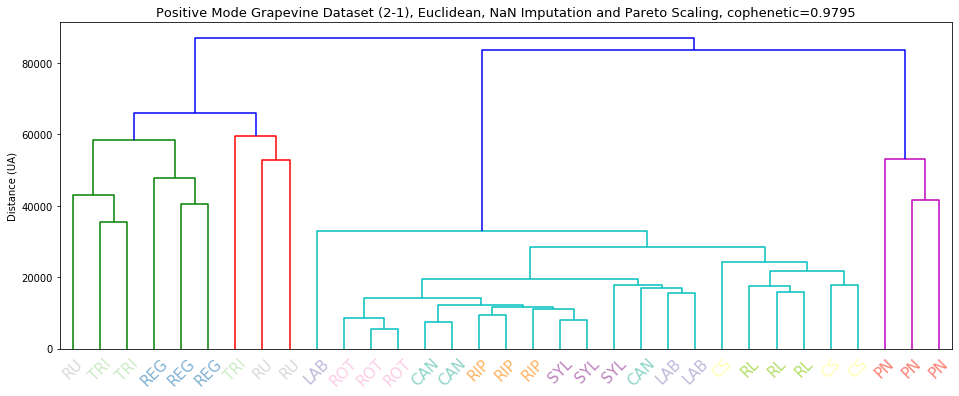

In [29]:
# Imputed and Pareto scaled
P_pos = treat_pos['P']
dist_P_pos = dist.pdist(P_pos.T, metric = 'euclidean')
Z_P_pos = hier.linkage(dist_P_pos, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_pos, dist_P_pos)[0] #method average seems to lead to higher coefficients
title = f'Positive Mode Grapevine Dataset (2-1), Euclidean, NaN Imputation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_P_pos, title)

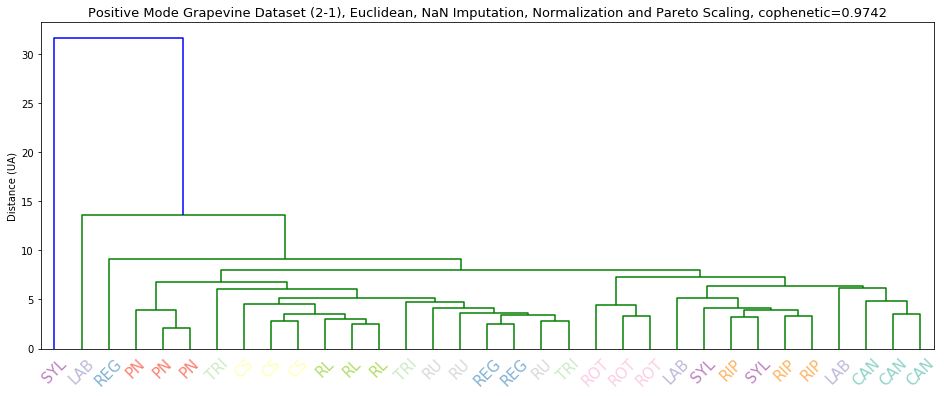

In [30]:
# Imputed, Normalized (reference feature) and Pareto scaled
NP_pos = treat_pos['NP']
dist_NP_pos = dist.pdist(NP_pos.T, metric = 'euclidean')
Z_NP_pos = hier.linkage(dist_NP_pos, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NP_pos, dist_NP_pos)[0] #method average seems to lead to higher coefficients
title = f'Positive Mode Grapevine Dataset (2-1), Euclidean, NaN Imputation, Normalization and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NP_pos, title)

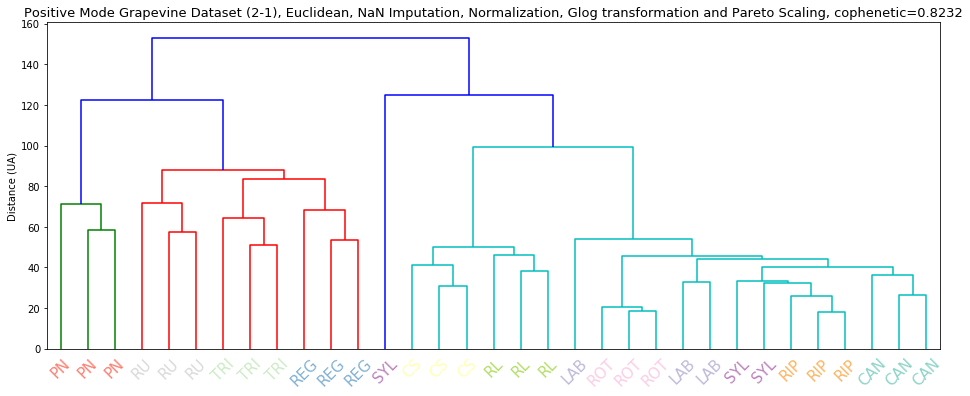

In [31]:
# Imputed, Normalized (reference feature), glog transformed and Pareto scaled
NGP_pos = treat_pos['NGP']
dist_NGP_pos = dist.pdist(NGP_pos.T, metric = 'euclidean')
Z_NGP_pos = hier.linkage(dist_NGP_pos, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_pos, dist_NGP_pos)[0] #method average seems to lead to higher coefficients
title = f'Positive Mode Grapevine Dataset (2-1), Euclidean, NaN Imputation, Normalization, Glog transformation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NGP_pos, title)

#### Binary Similarity Analysis Methods - Example Dendogram

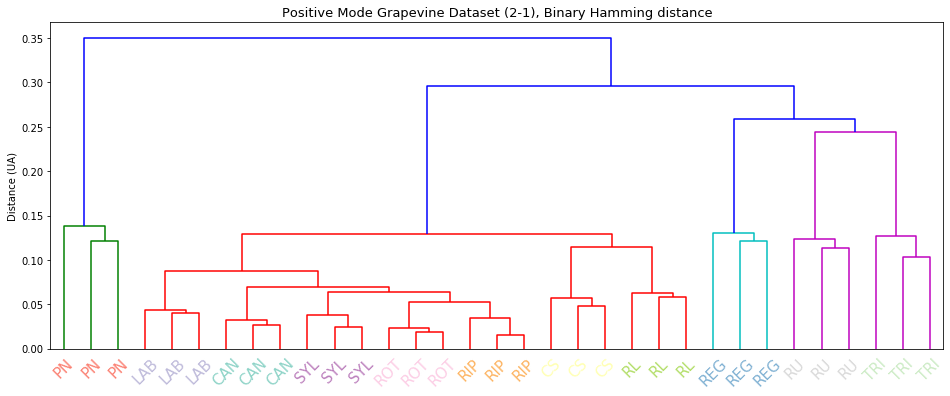

In [32]:
binary = treat_pos['binary']

#Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# print('Yeast dendrogram, Binary methods, Normalized by MetScape')
Zdice = hier.linkage(binary.T, metric='hamming', method='average')

title = f'Positive Mode Grapevine Dataset (2-1), Binary Hamming distance'
plot_dendogram(Zdice, title)

## 2nd Peak Alignment - 3-3

Presented with 2 following the names. Example: treat_neg2.

Same types of processing as before.

### 3-3 alignment 

Each feature appears in at least all replicates of a grapevine variety. Appears as 3_3 in figures.

In [33]:
aligned_all_pos2 = pd.HDFStore('alignments_new.h5').get('groups_1ppm_min3_all_1ppm_pos')
aligned_all_neg2 = pd.HDFStore('alignments_new.h5').get('groups_1ppm_min3_all_1ppm_neg')

#### Performing treatments

In [34]:
#Theoretical mass for negative mode Leucine Enkephalin - 554.2615.
RefEst_Neg = sca.search_for_ref_feat(aligned_all_neg2, 554.2615) #see if the function gives the reference feature
print(RefEst_Neg) #It did!

#Theoretical mass for positive mode Leucine Enkephalin - 556.2771.
RefEst_Pos = sca.search_for_ref_feat(aligned_all_pos2, 556.2771)
print(RefEst_Pos)

(554.26202, 0.0005200000000513683)
(556.27657, 0.0005300000000261207)


In [35]:
# Negative mode dataset
treat_neg2 = compute_transf(aligned_all_neg2, norm_ref = 554.26202)

# Positive mode dataset
treat_pos2 = compute_transf(aligned_all_pos2, norm_ref = 556.27657)

### Negative Mode - 3-3 Bias Alignment - Dendograms with each differently-treated Grapevine Dataset

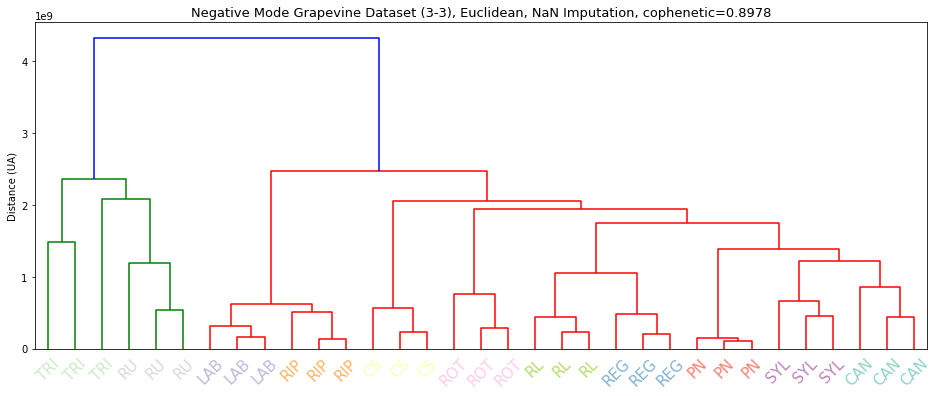

In [36]:
# Missing Value Imputation only
Imp_neg2 = treat_neg2['Ionly']
dist_Imp_neg2 = dist.pdist(Imp_neg2.T, metric = 'euclidean')
Z_Imp_neg2 = hier.linkage(dist_Imp_neg2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_Imp_neg2, dist_Imp_neg2)[0]

title = f'Negative Mode Grapevine Dataset (3-3), Euclidean, NaN Imputation, cophenetic={coph:.4f}'
plot_dendogram(Z_Imp_neg2, title)

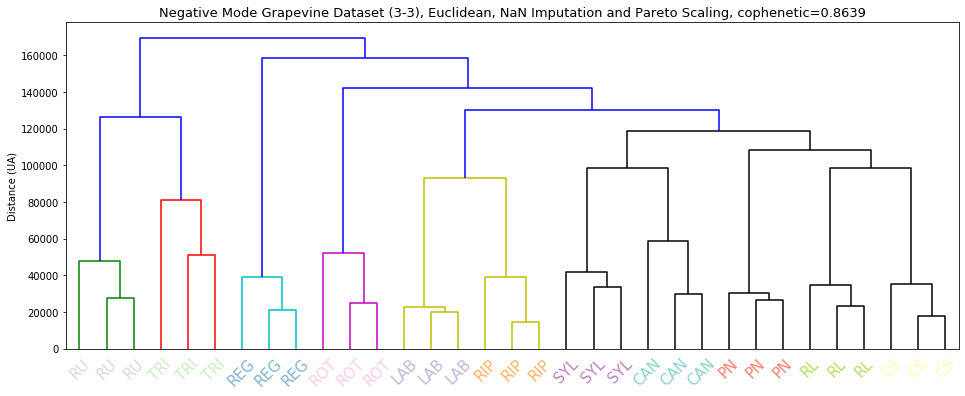

In [37]:
# Imputed and Pareto scaled
P_neg2 = treat_neg2['P']
dist_P_neg2 = dist.pdist(P_neg2.T, metric = 'euclidean')
Z_P_neg2 = hier.linkage(dist_P_neg2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_neg2, dist_P_neg2)[0] #method average seems to lead to higher coefficients
title = f'Negative Mode Grapevine Dataset (3-3), Euclidean, NaN Imputation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_P_neg2, title)

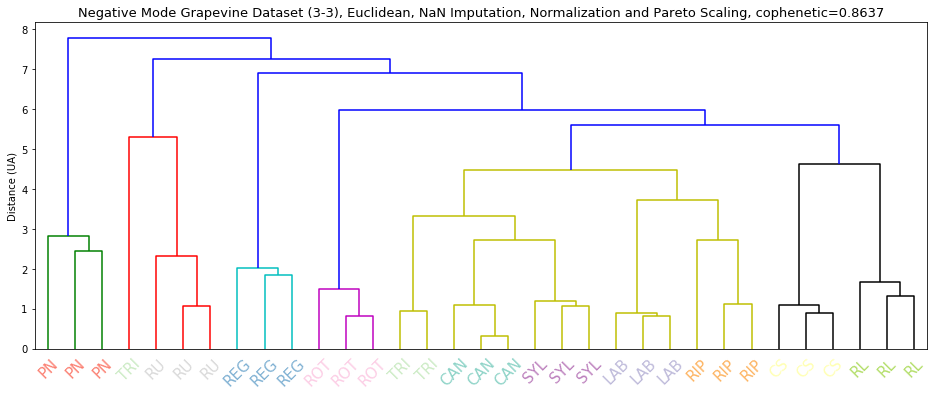

In [38]:
# Imputed, Normalized (reference feature) and Pareto scaled
NP_neg2 = treat_neg2['NP']
dist_NP_neg2 = dist.pdist(NP_neg2.T, metric = 'euclidean')
Z_NP_neg2 = hier.linkage(dist_NP_neg2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NP_neg2, dist_NP_neg2)[0] #method average seems to lead to higher coefficients
title = f'Negative Mode Grapevine Dataset (3-3), Euclidean, NaN Imputation, Normalization and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NP_neg2, title)

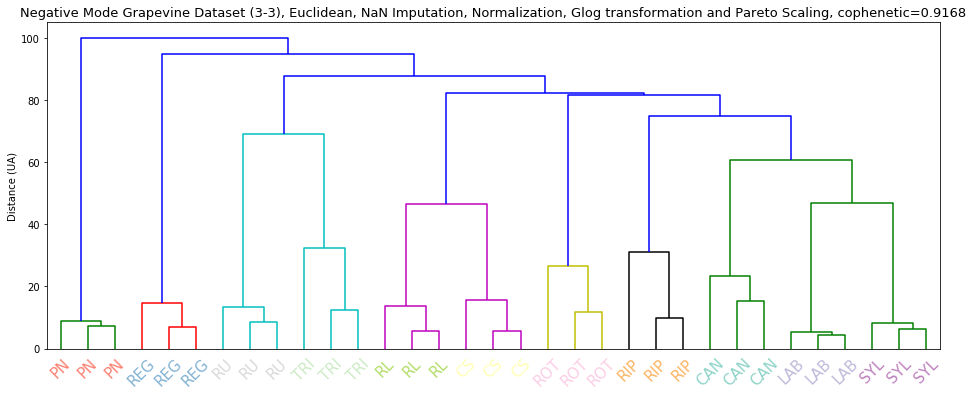

In [39]:
# Imputed, Normalized (reference feature), glog transformed and Pareto scaled
NGP_neg2 = treat_neg2['NGP']
dist_NGP_neg2 = dist.pdist(NGP_neg2.T, metric = 'euclidean')
Z_NGP_neg2 = hier.linkage(dist_NGP_neg2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_neg2, dist_NGP_neg2)[0] #method average seems to lead to higher coefficients
title = f'Negative Mode Grapevine Dataset (3-3), Euclidean, NaN Imputation, Normalization, Glog transformation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NGP_neg2, title)

#### Binary Similarity Analysis Methods - Example Dendogram

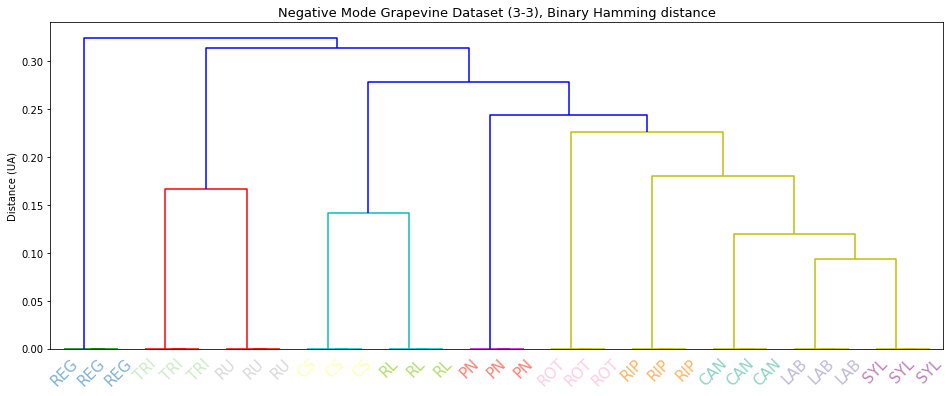

In [40]:
binary = treat_neg2['binary']

#Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# print('Yeast dendrogram, Binary methods, Normalized by MetScape')
Zdice = hier.linkage(binary.T, metric='hamming', method='average')

title = f'Negative Mode Grapevine Dataset (3-3), Binary Hamming distance'
plot_dendogram(Zdice, title)

### Positive Mode - 3-3 Bias Alignment - Dendograms with each differently-treated Grapevine Dataset

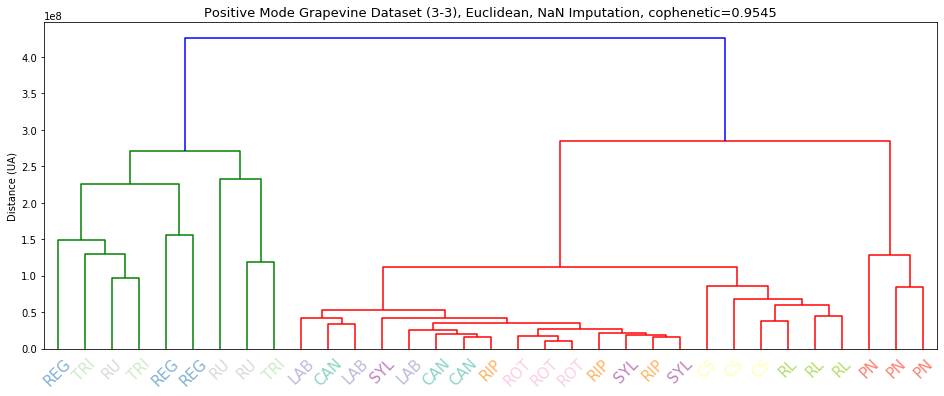

In [41]:
# Missing Value Imputation only
Imp_pos2 = treat_pos2['Ionly']
dist_Imp_pos2 = dist.pdist(Imp_pos2.T, metric = 'euclidean')
Z_Imp_pos2 = hier.linkage(dist_Imp_pos2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_Imp_pos2, dist_Imp_pos2)[0]

title = f'Positive Mode Grapevine Dataset (3-3), Euclidean, NaN Imputation, cophenetic={coph:.4f}'
plot_dendogram(Z_Imp_pos2, title)

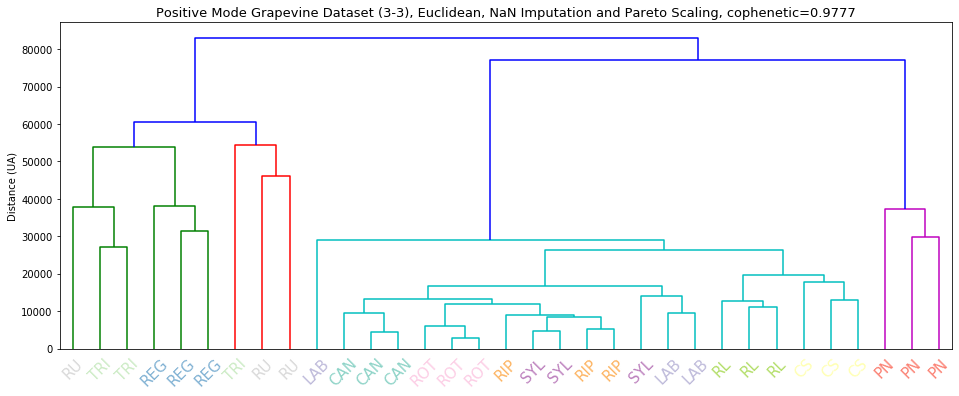

In [42]:
# Imputed and Pareto scaled
P_pos2 = treat_pos2['P']
dist_P_pos2 = dist.pdist(P_pos2.T, metric = 'euclidean')
Z_P_pos2 = hier.linkage(dist_P_pos2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_pos2, dist_P_pos2)[0] #method average seems to lead to higher coefficients
title = f'Positive Mode Grapevine Dataset (3-3), Euclidean, NaN Imputation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_P_pos2, title)

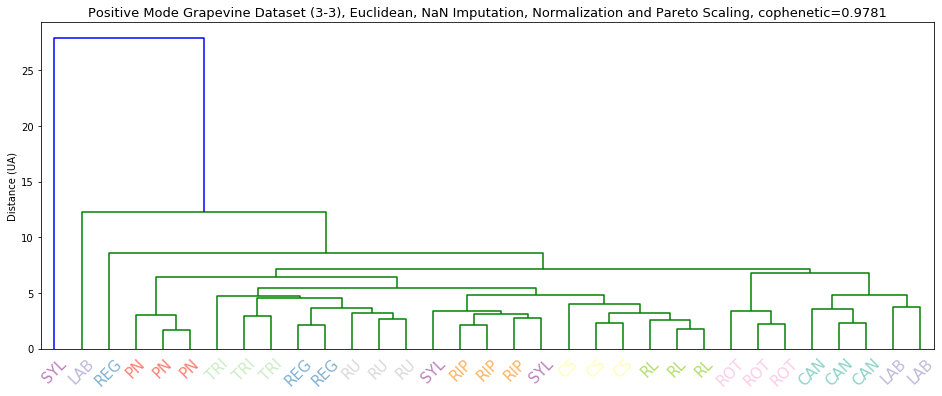

In [43]:
# Imputed, Normalized (reference feature) and Pareto scaled
NP_pos2 = treat_pos2['NP']
dist_NP_pos2 = dist.pdist(NP_pos2.T, metric = 'euclidean')
Z_NP_pos2 = hier.linkage(dist_NP_pos2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NP_pos2, dist_NP_pos2)[0] #method average seems to lead to higher coefficients
title = f'Positive Mode Grapevine Dataset (3-3), Euclidean, NaN Imputation, Normalization and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NP_pos2, title)

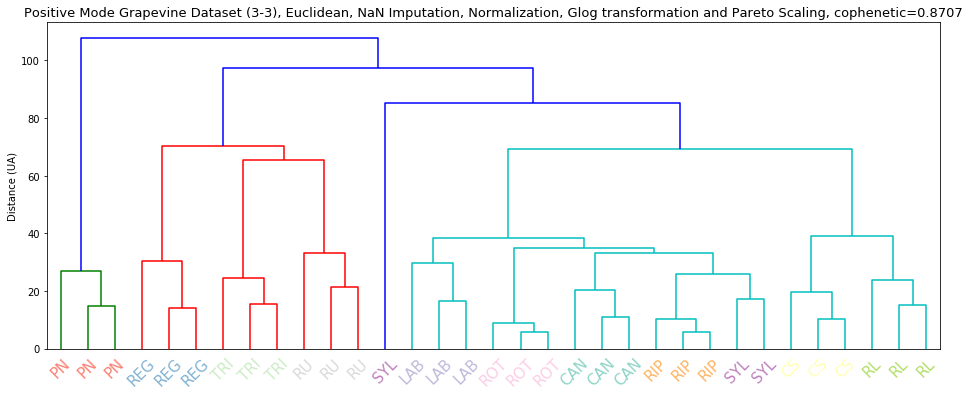

In [44]:
# Imputed, Normalized (reference feature), glog transformed and Pareto scaled
NGP_pos2 = treat_pos2['NGP']
dist_NGP_pos2 = dist.pdist(NGP_pos2.T, metric = 'euclidean')
Z_NGP_pos2 = hier.linkage(dist_NGP_pos2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_pos2, dist_NGP_pos2)[0] #method average seems to lead to higher coefficients
title = f'Positive Mode Grapevine Dataset (3-3), Euclidean, NaN Imputation, Normalization, Glog transformation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NGP_pos2, title)

#### Binary Similarity Analysis Methods - Example Dendogram

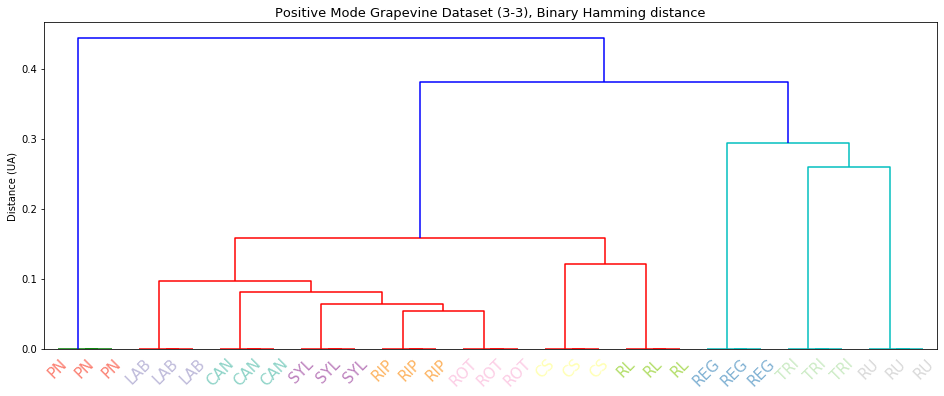

In [45]:
binary = treat_pos2['binary']

#Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# print('Yeast dendrogram, Binary methods, Normalized by MetScape')
Zdice = hier.linkage(binary.T, metric='hamming', method='average')

title = f'Positive Mode Grapevine Dataset (3-3), Binary Hamming distance'
plot_dendogram(Zdice, title)

### Comparing Dendrograms

#### Two methods so far: Baker's Gamma Correlation and Cophenetic Correlation Coefficient

#### Examples of procedure with these methods

#### Baker's method

Use of the mergerank function from multianalysis to create a 'rank' of the iteration number two samples were linked to the same cluster.

#### Imp/Ionly not used in this comparison

In [46]:
euclidean = (Z_P_neg, Z_NP_neg, Z_NGP_neg, Z_P_pos, Z_NP_pos, Z_NGP_pos,
            Z_P_neg2, Z_NP_neg2, Z_NGP_neg2, Z_P_pos2, Z_NP_pos2, Z_NGP_pos2)
dist_euclidean = (dist_P_neg, dist_NP_neg, dist_NGP_neg, dist_P_pos, dist_NP_pos, dist_NGP_pos,
                 dist_P_neg2, dist_NP_neg2, dist_NGP_neg2, dist_P_pos2, dist_NP_pos2, dist_NGP_pos2)

K_BG = []
S_BG = []
Coph_C = []

for i, (eu, d) in enumerate(zip(euclidean, dist_euclidean)):
    K_BG.append(ma.mergerank(eu)) # Mergerank
    S_BG.append(K_BG[i][K_BG[i]!=0]) # Both reshape to a 1D array (needed for spearman correlation) and take out 0's 
    Coph_C.append(hier.cophenet(eu, d)) # Matrix of Cophenetic distances

#### Examples

According to Original Paper (Stability of Two Hierarchical Grouping Techniques Case 1: Sensitivity to Data Errors)

In [47]:
print('Pair of samples      \tKendall Correlation \tp-value')
print('Euc_P_neg-Euc_NP_neg\t', stats.kendalltau(S_BG[0],S_BG[1])[0], '\t', stats.kendalltau(S_BG[0],S_BG[1])[1])
print('Euc_P_neg-Euc_NGP_neg\t', stats.kendalltau(S_BG[0],S_BG[2])[0], '\t', stats.kendalltau(S_BG[0],S_BG[2])[1])

Pair of samples      	Kendall Correlation 	p-value
Euc_P_neg-Euc_NP_neg	 0.4415768716061203 	 1.3939970741508724e-82
Euc_P_neg-Euc_NGP_neg	 0.36161285754054767 	 5.0106890056174584e-54


According to the explanation given in the R package dendextend

In [48]:
print('Pair of samples      \tSpearman Correlation \tp-value')
print('Euc_P_neg-Euc_NP_neg\t', stats.spearmanr(S_BG[0],S_BG[1])[0], '\t', stats.spearmanr(S_BG[0],S_BG[1])[1])
print('Euc_P_neg-Euc_NGP_neg\t', stats.spearmanr(S_BG[0],S_BG[2])[0], '\t', stats.spearmanr(S_BG[0],S_BG[2])[1])

Pair of samples      	Spearman Correlation 	p-value
Euc_P_neg-Euc_NP_neg	 0.5683898314972229 	 2.1502519724864813e-91
Euc_P_neg-Euc_NGP_neg	 0.43236916929432456 	 2.435157446010864e-49


#### Cophenetic Correlation Coefficient

In [49]:
#Acho que se pode aplicar logo a função np.corrcoef visto os elementos que vêm da função cophenet estão sempre na mesma ordem 
#uns em relação aos outros.

In [50]:
print('Pair of samples      \tPearson Correlation \tp-value')
print('Euc_P_neg-Euc_NP_neg\t', stats.pearsonr(Coph_C[0][1],Coph_C[1][1])[0], '\t', stats.pearsonr(Coph_C[0][1],Coph_C[1][1])[1])
print('Euc_P_neg-Euc_NGP_neg\t', stats.pearsonr(Coph_C[0][1],Coph_C[2][1])[0], '\t', stats.pearsonr(Coph_C[0][1],Coph_C[2][1])[1])

Pair of samples      	Pearson Correlation 	p-value
Euc_P_neg-Euc_NP_neg	 0.7254243252702025 	 2.2472891841457184e-87
Euc_P_neg-Euc_NGP_neg	 0.6374772181916993 	 1.475240245943776e-61


### Comparison of dendrograms made with all binary metrics and euclidean distances 

#### Correlations between all pairs using all 3 methods

Change between number of binary metrics to use

In [51]:
#9 binary methods accepted in pdist (scipy.spatial.distances.pdist)
binary = ('dice', 'hamming', 'jaccard', 'rogerstanimoto', 'sokalmichener', 'sokalsneath', 'yule', 'kulsinski', 'russellrao')
#3 methods that will be used as representative of the others (others not present have similar variations to one of those 3)
#binary = ( 'jaccard', 'hamming', 'yule')

In [52]:
aligned_neg = treat_neg['binary']
aligned_pos = treat_pos['binary']
aligned_neg2 = treat_neg2['binary']
aligned_pos2 = treat_pos2['binary']

In [53]:
#Application of all "single" steps needed presented in the examples above with every distance metric.
#Negative mode
Z_neg = []
K_neg = []
S_neg = []
Coph_neg = []

for i in range(len(binary)):
    Z_neg.append(hier.linkage(aligned_neg.T, metric = binary[i], method='average')) #Z
    K_neg.append(ma.mergerank(Z_neg[i])) #Mergerank
    S_neg.append(K_neg[i][K_neg[i]!=0]) #Eliminating 0's
    Coph_neg.append(hier.cophenet(Z_neg[i], dist.pdist(aligned_neg.T, metric = binary[i]))) #Cophenetic

In [54]:
#Positive Mode
Z_pos = []
K_pos = []
S_pos = []
Coph_pos = []

for i in range(len(binary)):
    Z_pos.append(hier.linkage(aligned_pos.T, metric = binary[i], method='average')) #Z
    K_pos.append(ma.mergerank(Z_pos[i])) #Mergerank
    S_pos.append(K_pos[i][K_pos[i]!=0]) #Eliminating 0's
    Coph_pos.append(hier.cophenet(Z_pos[i], dist.pdist(aligned_pos.T, metric = binary[i]))) #Cophenetic

In [55]:
#Creation of a list with all the "rank" values (in order) for the different metrics: 
#Negative Euclideans, Positive Euclideans, Negative Binaries, Positive Binaries
S = S_BG + S_neg + S_pos

#Creation of a list with all the returns from the function cophenetic for the different metrics: 
#Negative Euclideans, Positive Euclideans, Negative Binaries, Positive Binaries
Coph = Coph_C + Coph_neg + Coph_pos

Creation of all dataframes needed to store all correlation coeficients and respective p-values fot all three methods

In [56]:
#Column names and row names for the dataframes
#3 binary metrics
#colnames = ['P_neg2_1', 'NP_neg2_1', 'NGP_neg2_1', 'P_pos2_1', 'NP_pos2_1', 'NGP_pos2_1',
            #'P_neg3_3', 'NP_neg3_3', 'NGP_neg3_3', 'P_pos3_3', 'NP_pos3_3', 'NGP_pos3_3',
#            'hamming_neg3_3', 'jaccard_neg3_3', 'yule_neg3_3',  'hamming_pos3_3', 'jaccard_pos3_3', 'yule_pos3_3']

#9 binary metrics
colnames = ['P_neg2_1', 'NP_neg2_1', 'NGP_neg2_1', 'P_pos2_1', 'NP_pos2_1', 'NGP_pos2_1','P_neg3_3',
            'NP_neg3_3', 'NGP_neg3_3', 'P_pos3_3', 'NP_pos3_3', 'NGP_pos3_3','dice_neg2_1', 'hamming_neg2_1',
            'jaccard_neg2_1', 'rogerstanimoto_neg2_1', 'sokalmichener_neg2_1', 'sokalsneath_neg2_1','yule_neg2_1', 
            'kulsinski_neg2_1', 'russellrao_neg2_1','dice_pos2_1', 'hamming_pos2_1', 'jaccard_pos2_1', 'rogerstanimoto_pos2_1', 
            'sokalmichener_pos2_1', 'sokalsneath_pos2_1', 'yule_pos2_1', 'kulsinski_pos2_1', 'russellrao_pos2_1']

In [57]:
nS = len(S)
correlations = {key: np.zeros((nS,nS)) for key in ('K', 'S', 'C', 'K_p', 'S_p', 'C_p')}

for i in range(nS):
    for j in range(nS):
        Si, Sj = S[i],S[j]
        # K - Kendall (Baker)
        ktau = stats.kendalltau(Si,Sj)
        correlations['K'][i,j], correlations['K_p'][i,j] = ktau
        # S - Spearman (Baker)
        spearmanr = stats.stats.spearmanr(Si,Sj)
        correlations['S'][i,j], correlations['S_p'][i,j] = spearmanr
        # C - Cophenetic Correlation
        coph = stats.pearsonr(Coph[i][1],Coph[j][1])
        correlations['C'][i,j], correlations['C_p'][i,j] = coph

for k in correlations:
    correlations[k] = pd.DataFrame(correlations[k], columns=colnames, index=colnames)

In [58]:
#Calculation of correlation coefficient for each method

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,nS))* np.nan, columns=colnames, index=[''])
lineV = pd.concat([line.iloc[:,:12], pd.DataFrame(np.empty((1,1))* np.nan, columns =[''], index = ['']), line.iloc[:,12:]], axis = 1)

def prepare_corr_df(df):
    prep = pd.concat([df.iloc[:12], line, df.iloc[12:]])
    prep = pd.concat([prep.iloc[:,:12], lineV.T, prep.iloc[:,12:]], axis = 1)
    return prep

df_KI = prepare_corr_df(correlations['K'])
df_SI = prepare_corr_df(correlations['S'])
df_CI = prepare_corr_df(correlations['C'])

### Heatmaps of the correlation coeficients for the 3 methods

Baker (Kendall) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 12: DataProcessing_Dataset; Last 18: DistanceMetric_Dataset
2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety
3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety


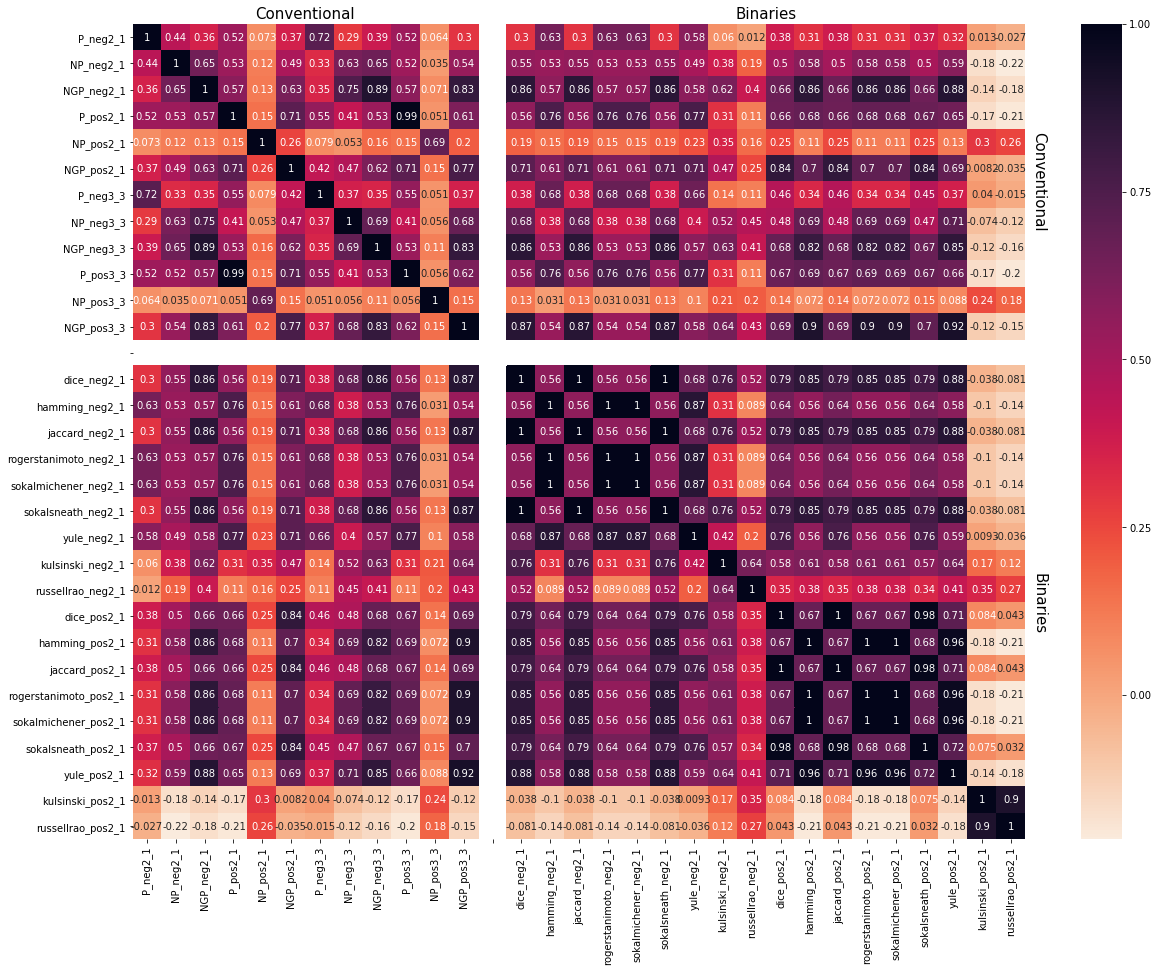

In [59]:
f, ax = plt.subplots(figsize=(20, 15))

print('Baker (Kendall) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 12: DataProcessing_Dataset; Last 18: DistanceMetric_Dataset')
print('2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety')
print('3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety')
hm = sns.heatmap(df_KI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(6,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(31.2,6,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(22,-0.2,'Binaries', fontsize = 15, horizontalalignment='center') #16
plt.text(31.2,22,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center') #16
plt.show()

In [60]:
Kendall = pd.DataFrame(np.zeros((9, 5)), index = ('dice', 'hamming', 'jaccard', 'rogerstanimoto', 'sokalmichener', 'sokalsneath', 
                                                 'yule', 'kulsinski', 'russellrao'), columns = ('neg2-1', 'pos2-1', 'neg3-3', 
                                                                                                'pos3-3', 'neg+pos'))

for j in range(5):
    for r in range(9):
        if j in [0,2]:
            Kendall.iloc[r,j] = df_KI.iloc[13+r,j*3+2]#sum(df_KI.iloc[13+r,j*3:j*3+3])
        elif j in [1,3]:
            Kendall.iloc[r,j] = df_KI.iloc[22+r,j*3+2]#sum(df_KI.iloc[22+r,j*3:j*3+3])
        else:
            Kendall.iloc[r,j] = sum(Kendall.iloc[r,0:4])
#f, ax = plt.subplots(figsize=(5, 4))
#hm = sns.heatmap(Kendall, annot=True, ax=ax, cmap = sns.cm.rocket_r)
#bottom, top = ax.get_ylim()
#ax.set_ylim(bottom + 0.5, top - 0.5)
#plt.show()
Kendall

,neg2-1,pos2-1,neg3-3,pos3-3,neg+pos
dice,0.858599,0.842311,0.858947,0.694926,3.254782
hamming,0.566603,0.700700,0.527539,0.902626,2.697468
jaccard,0.858599,0.842232,0.858947,0.694851,3.254629
rogerstanimoto,0.566603,0.700700,0.527539,0.902626,2.697468
sokalmichener,0.566603,0.700700,0.527539,0.902626,2.697468
sokalsneath,0.858599,0.843401,0.858947,0.698777,3.259722
yule,0.576943,0.690802,0.568235,0.920495,2.756475
kulsinski,0.621447,0.008202,0.633562,-0.116197,1.147014
russellrao,0.397959,-0.034778,0.410562,-0.153162,0.620581


Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 12: DataProcessing_Dataset; Last 18: DistanceMetric_Dataset
2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety
3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety


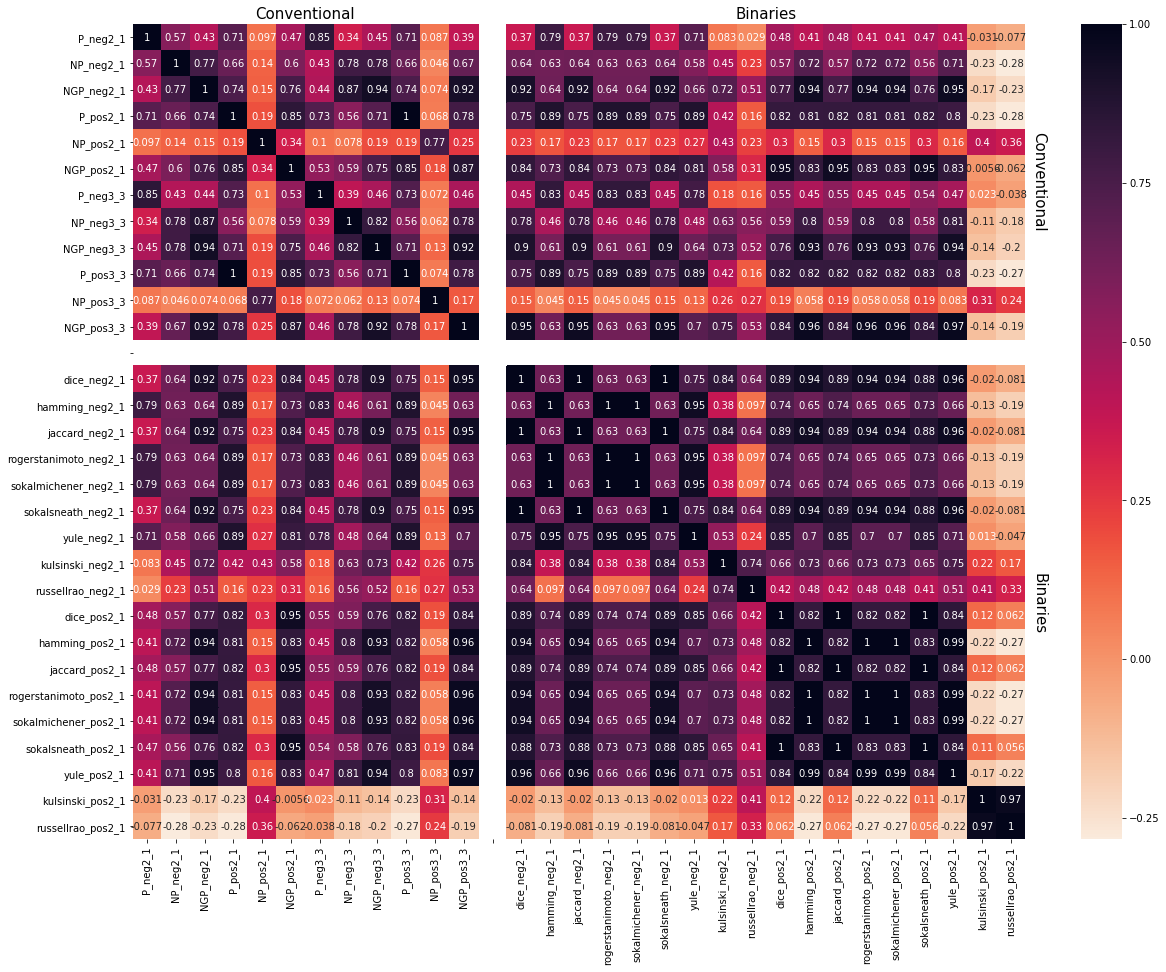

In [61]:
f, ax = plt.subplots(figsize=(20, 15))

print('Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 12: DataProcessing_Dataset; Last 18: DistanceMetric_Dataset')
print('2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety')
print('3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety')
hm = sns.heatmap(df_SI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(6,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(31.2,6,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(22,-0.2,'Binaries', fontsize = 15, horizontalalignment='center') #16
plt.text(31.2,22,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center') #16
plt.show()

Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 12: DataProcessing_Dataset; Last 18: DistanceMetric_Dataset
2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety
3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety


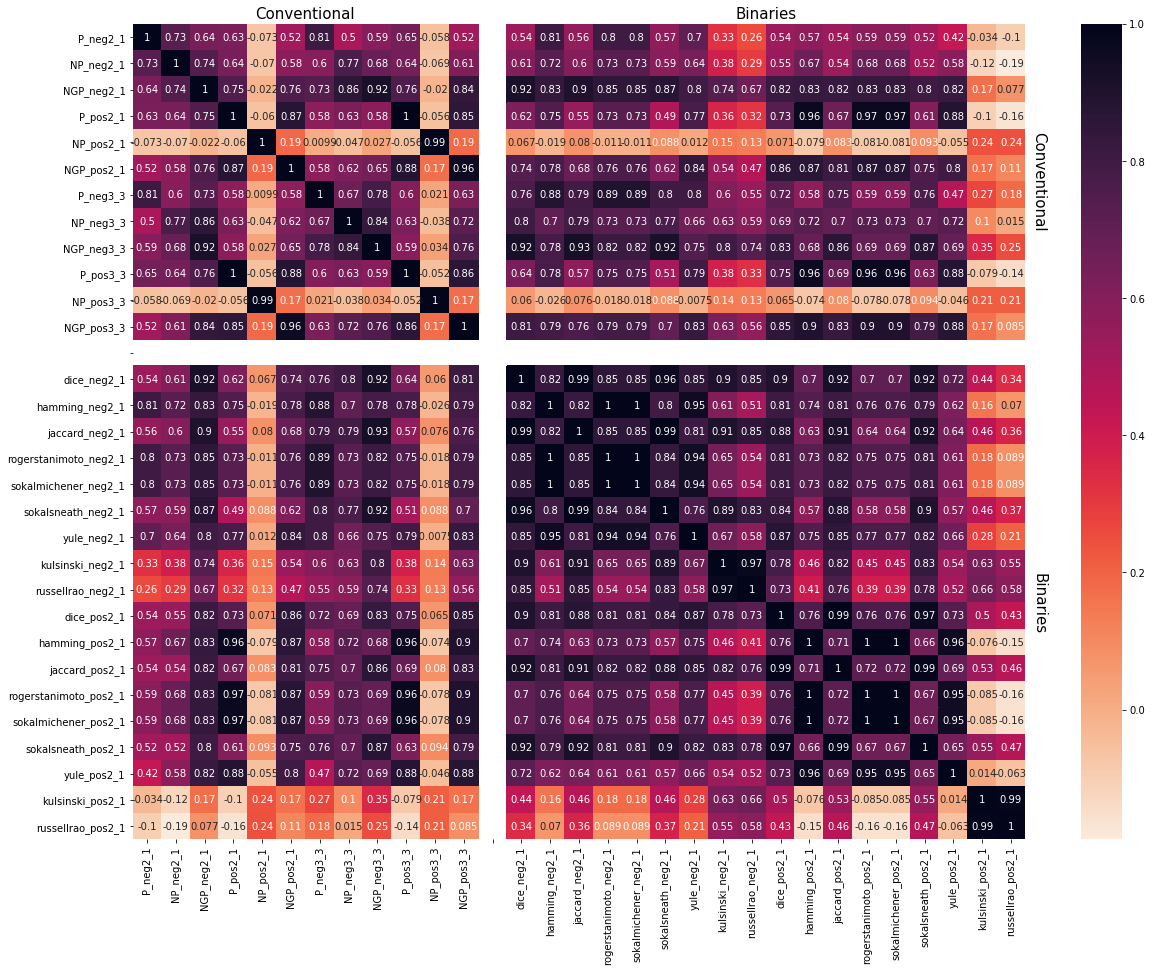

In [62]:
f, ax = plt.subplots(figsize=(20, 15))

print('Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 12: DataProcessing_Dataset; Last 18: DistanceMetric_Dataset')
print('2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety')
print('3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety')
hm = sns.heatmap(df_CI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(6,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(31.2,6,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(22,-0.2,'Binaries', fontsize = 15, horizontalalignment='center') #16
plt.text(31.2,22,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center') #16
plt.show()

In [63]:
Cophenetic = pd.DataFrame(np.zeros((9, 5)), index = ('dice', 'hamming', 'jaccard', 'rogerstanimoto', 'sokalmichener', 'sokalsneath', 
                                                 'yule', 'kulsinski', 'russellrao'), columns = ('neg2-1', 'pos2-1', 'neg3-3', 
                                                                                                'pos3-3','neg+pos'))
for j in range(5):
    for r in range(9):
        if j in [0,2]:
            Cophenetic.iloc[r,j] = df_CI.iloc[13+r,j*3+2]#sum(df_CI.iloc[13+r,j*3:j*3+3])
        elif j in [1,3]:
            Cophenetic.iloc[r,j] = df_CI.iloc[22+r,j*3+2]#sum(df_CI.iloc[22+r,j*3:j*3+3])
        else:
            Cophenetic.iloc[r,j] = sum(Cophenetic.iloc[r,0:4])
Cophenetic

,neg2-1,pos2-1,neg3-3,pos3-3,neg+pos
dice,0.916591,0.858258,0.921402,0.851750,3.548001
hamming,0.833542,0.865267,0.784969,0.899475,3.383253
jaccard,0.899845,0.809474,0.928369,0.825598,3.463286
rogerstanimoto,0.854385,0.871918,0.816056,0.901846,3.444205
sokalmichener,0.854385,0.871918,0.816056,0.901846,3.444205
sokalsneath,0.872666,0.754614,0.918720,0.790700,3.336700
yule,0.797975,0.800291,0.746030,0.876932,3.221228
kulsinski,0.738756,0.167634,0.801400,0.166262,1.874051
russellrao,0.666156,0.111652,0.735593,0.085476,1.598877


### Hierarchical clustering of the correlation coeficients of dendrograms made with different distance metrics with each other

Colours for these labels (groups: neg_peakalignment1, pos_peakalignment1, neg_peakalignment2, pos_peakalignment2, neg_binary, pos_binary

In [64]:
label_colors2 = {}
colours2 = cm.get_cmap('nipy_spectral', 6)
col_lbl2 = colours2(range(6))
for i in range(4):
    label_colors2[colnames[3*i]] = col_lbl2[i]
    label_colors2[colnames[3*i+1]] = col_lbl2[i]
    label_colors2[colnames[3*i+2]] = col_lbl2[i]
for i in range(9):
    label_colors2[colnames[12+i]] = col_lbl2[4]
    label_colors2[colnames[21+i]] = col_lbl2[5]

Hierarchical clustering of the Baker (Kendall) Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: First 12: DataProcessing_Dataset; Last 18: DistanceMetric_Dataset
2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety
3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety


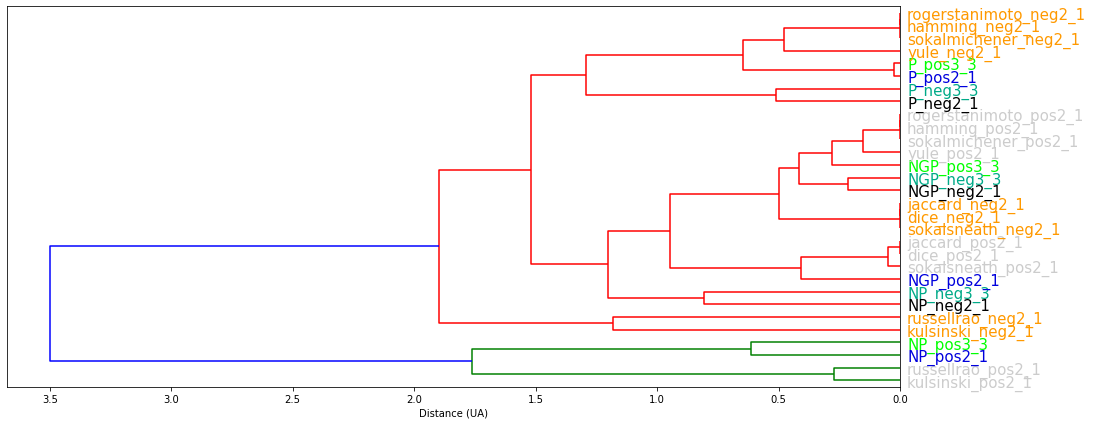

In [65]:
print('Hierarchical clustering of the Baker (Kendall) Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: First 12: DataProcessing_Dataset; Last 18: DistanceMetric_Dataset')
print('2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety')
print('3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety')
Z_K = hier.linkage(correlations['K'], metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_K, labels=colnames,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

Hierarchical clustering of the Baker (Spearman) Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: First 12: DataProcessing_Dataset; Last 18: DistanceMetric_Dataset
2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety
3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety


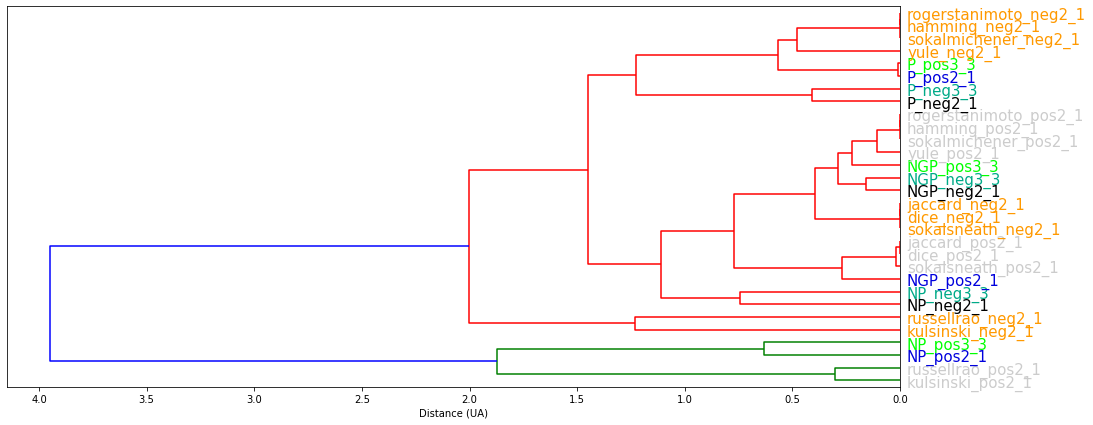

In [66]:
print('Hierarchical clustering of the Baker (Spearman) Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: First 12: DataProcessing_Dataset; Last 18: DistanceMetric_Dataset')
print('2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety')
print('3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety')
Z_S = hier.linkage(correlations['S'], metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_S, labels=colnames,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

Hierarchical clustering of the Cophenetic Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: First 12: DataProcessing_Dataset; Last 18: DistanceMetric_Dataset
2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety
3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety


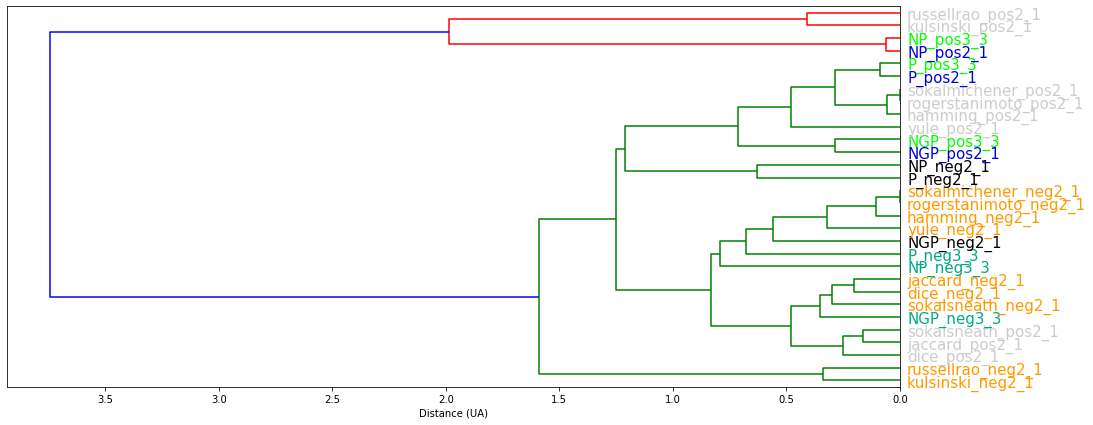

In [67]:
print('Hierarchical clustering of the Cophenetic Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: First 12: DataProcessing_Dataset; Last 18: DistanceMetric_Dataset')
print('2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety')
print('3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety')
Z_C = hier.linkage(correlations['C'], metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_C, labels=colnames,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

### Distance discrimination of all methods applied (and shown in previous heatmap/dendrogram).

In [68]:
#Preparing Z linkage matrices
Z = []
Z.extend(euclidean)
Z.extend(Z_neg)
Z.extend(Z_pos)

In [69]:
disc_average = np.zeros((1,30))
disc_median = np.zeros((1,30))
disc_correct = np.zeros((1,30))
disc_goodclust = np.zeros((1,30))

for i in range(len(Z)):
    data = aligned_all_neg
    discrim = ma.dist_discrim(data, Z[i], method = 'average')  #all samples have the same order
    disc_average[0,i] = discrim[0]
    disc_median[0,i] = ma.dist_discrim(data, Z[i], 'median')[0] #all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])
    disc_goodclust[0,i] = ma.good_first_cluster_fraction(data, Z[i]) #all samples have the same order

#Transforming results into DataFrames    
disc_average = pd.DataFrame(disc_average, index = ['distances average'], columns = colnames)
disc_median = pd.DataFrame(disc_median, index = ['distances median'], columns = colnames)
disc_correct = pd.DataFrame(disc_correct, index = ['correct groupings'], columns = colnames)
disc_goodclust = pd.DataFrame(disc_goodclust, index = ['% good 1st cluster'], columns = colnames)

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,1))* np.nan, index = [''])
disc_average = pd.concat([disc_average.iloc[:,:12], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances average']).T, disc_average.iloc[:,12:]], axis = 1)
disc_median = pd.concat([disc_median.iloc[:,:12], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances median']).T, disc_median.iloc[:,12:]], axis = 1)
disc_correct = pd.concat([disc_correct.iloc[:,:12], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['correct groupings']).T, disc_correct.iloc[:,12:]], axis = 1)
disc_goodclust = pd.concat([disc_goodclust.iloc[:,:12], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['% good 1st cluster']).T, disc_goodclust.iloc[:,12:]], axis = 1)

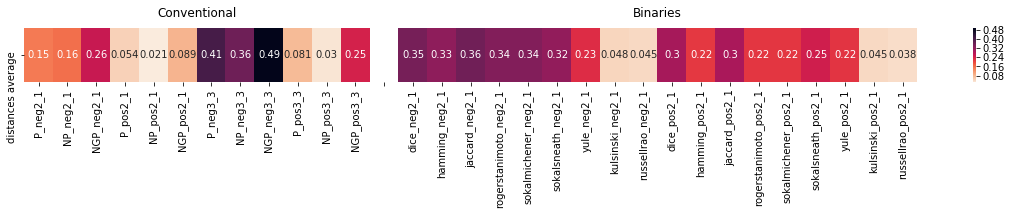

In [70]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.text(6,-0.2,'Conventional', fontsize  = 12, horizontalalignment='center')
plt.text(22,-0.2,'Binaries', fontsize = 12, horizontalalignment='center')
plt.show()

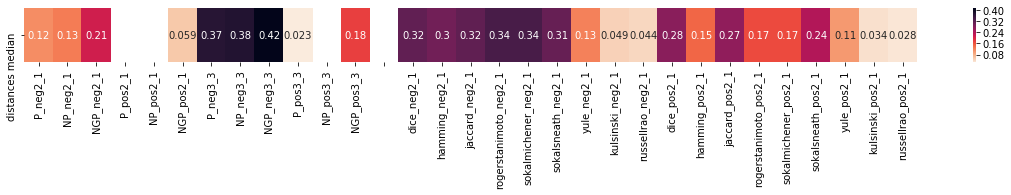

In [71]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

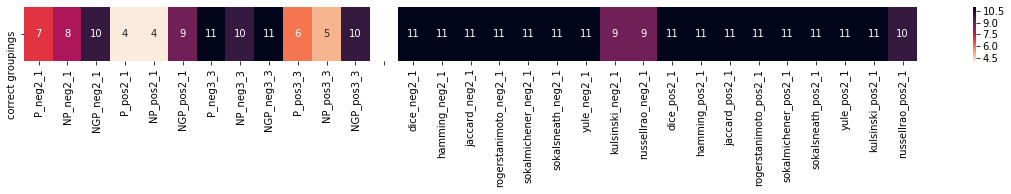

In [72]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

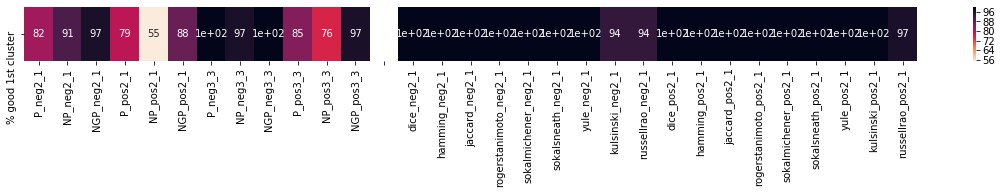

In [73]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_goodclust*100, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### K-means clustering

In [74]:
import sklearn.cluster as skclust

#### Example of what happens in a K-means clustering and how samples are separated 
Use of the module do sci-kit learn - sklearn. Cluster number equal to the amount of varieties. How well can this method separate the varieties. Default parameters except number of clusters.

This example doesn't necessarily mirror the results below (for the case in example) since K-means clustering has an intrinsically random side to it and the clustering is performed again for the case example.

In [75]:
Kmean = skclust.KMeans(n_clusters=11)

In [76]:
a = Kmean.fit(NGP_neg.T)
a.inertia_

22458.80889981587

In [77]:
dicto = {}

for i, lbl in enumerate(a.labels_):
    dicto.setdefault(lbl, []).append(all_labels[i])
dicto

{9: ['CAN', 'CAN', 'CAN'],
 4: ['CS', 'CS', 'CS', 'RL', 'RL', 'RL'],
 7: ['LAB', 'LAB', 'LAB'],
 0: ['PN', 'PN', 'PN'],
 6: ['REG', 'REG', 'REG'],
 1: ['RIP', 'RIP', 'RIP'],
 5: ['ROT', 'ROT', 'ROT'],
 3: ['RU', 'RU', 'RU'],
 2: ['SYL', 'SYL', 'SYL'],
 8: ['TRI', 'TRI'],
 10: ['TRI']}

Adjusted Rand Index

In [78]:
from sklearn.metrics import adjusted_rand_score
a.labels_
NGP_neg.cdl.labels
adjusted_rand_score(NGP_neg.cdl.labels,a.labels_)

0.8382352941176471

### K-means clustering applied to all euclidean methods and the binary matrixes built

To try and get a condensed and more easily digestible version of the results, a method similar to the discrimination distance performed in the hierarchical clustering was made. The same metrics as before are used.

Replicates of a variety can be together in a cluster but, if there are more samples in the same cluster, its "discrimination distance" is still zero. Therefore, this method is harsher than the original dist_discrim method. The distance is calculated as the distance between the centroid of the cluster where the samples are and the closest centroid. This distance is normalized by dividing it by the maximum distance between any 2 centroids of the clusters formed. The mean/median of the discrimination distances of all groups is then a measure of the global discrimination distance

Use of the `Kmeans_discrim` function from multianalysis to calculate discrimination distance.

In [79]:
colnames2 = ['P_neg2_1', 'NP_neg2_1', 'NGP_neg2_1', 'P_pos2_1', 'NP_pos2_1', 'NGP_pos2_1',
             'P_neg3_3', 'NP_neg3_3', 'NGP_neg3_3', 'P_pos3_3', 'NP_pos3_3', 'NGP_pos3_3',
             'binary_neg2_1', 'binary_pos2_1','binary_neg3_3', 'binary_pos3_3']

In [80]:
Data = (P_neg, NP_neg, NGP_neg, P_pos, NP_pos, NGP_pos,
        P_neg2, NP_neg2, NGP_neg2, P_pos2, NP_pos2, NGP_pos2, 
        aligned_neg, aligned_pos, aligned_neg2, aligned_pos2)

In [81]:
disc_average = np.zeros((1,16))
#disc_median = np.zeros((1,16))
disc_correct = np.zeros((1,16))
disc_rand = np.zeros((1,16))

for i in range(len(Data)):
    discrim = ma.Kmeans_discrim(Data[i], method = 'average', iter_num=150, best_fraction=0.1)
    
    #Lists for the results of the best k-means clustering
    average = []
    correct = []
    rand = []
    for j in discrim:
        average.append(discrim[j][0]) #Discrimination Distances
        all_correct = np.array(list(discrim[j][1].values()))
        correct.append(len(all_correct[all_correct>0])) #Correct Clustering Percentages
        rand.append(discrim[j][2]) #Rand Index
    
    #Putting results into the arrays - median of the best k-means clustering
    disc_average[0,i] = np.median(average) 
    disc_correct[0,i] = np.median(correct)
    disc_rand[0,i] = np.median(rand)

#Transforming into DataFrame
disc_average = pd.DataFrame(disc_average, index = ['distances average'], columns = colnames2)
disc_correct = pd.DataFrame(disc_correct/11*100, index = ['correct groupings'], columns = colnames2)
disc_rand = pd.DataFrame(disc_rand, index = ['correct groupings'], columns = colnames2)

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,1))* np.nan, index = [''])
disc_average = pd.concat([disc_average.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances average']).T, disc_average.iloc[:,6:12], 
                                                pd.DataFrame(np.empty((1,1))* np.nan, index = [''], columns = 
                                                ['distances average']).T, disc_average.iloc[:,12:]], axis = 1)
disc_correct = pd.concat([disc_correct.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['correct groupings']).T, disc_correct.iloc[:,6:12], 
                                                pd.DataFrame(np.empty((1,1))* np.nan, index = [''], columns = 
                                                ['correct groupings']).T, disc_correct.iloc[:,12:]], axis = 1)
disc_rand = pd.concat([disc_rand.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['correct groupings']).T, disc_rand.iloc[:,6:12], 
                                                pd.DataFrame(np.empty((1,1))* np.nan, index = [''], columns = 
                                                ['correct groupings']).T, disc_rand.iloc[:,12:]], axis = 1)

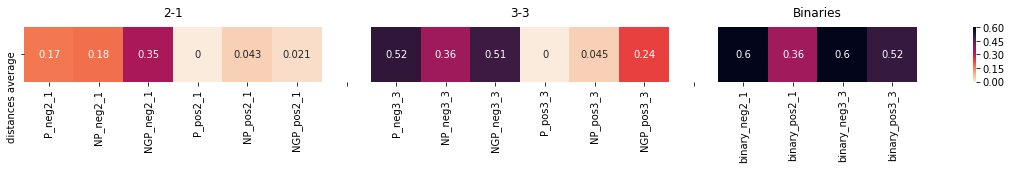

In [82]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.text(3,-0.2,'2-1', fontsize  = 12, horizontalalignment='center')
plt.text(10,-0.2,'3-3', fontsize  = 12, horizontalalignment='center')
plt.text(16,-0.2,'Binaries', fontsize = 12, horizontalalignment='center')
plt.show()

In [83]:
#f, ax = plt.subplots(figsize=(20, 1))
#hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

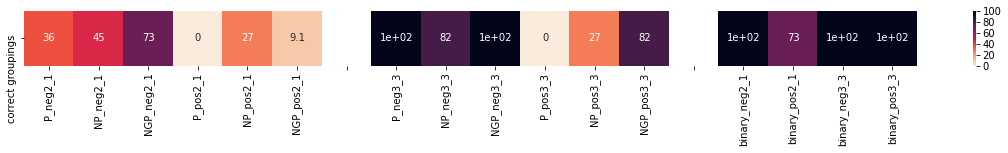

In [84]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

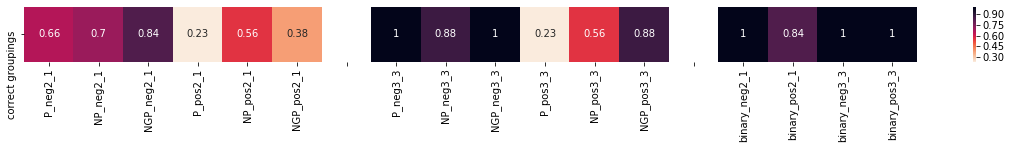

In [85]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_rand, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### RandomForests Attempts - 3-fold cross-validation, n_estimators = 200

This section of the notebook takes some time.

In [86]:
# Centralize data information in a dictionary
datasets = {}

datasets['I_neg'] = treat_neg['Ionly']
datasets['P_neg'] = treat_neg['P']
datasets['NP_neg'] = treat_neg['NP']
datasets['NGP_neg'] = treat_neg['NGP']
datasets['bin_neg'] = treat_neg['binary']

datasets['I_pos'] = treat_pos['Ionly']
datasets['P_pos'] = treat_pos['P']
datasets['NP_pos'] = treat_pos['NP']
datasets['NGP_pos'] = treat_pos['NGP']
datasets['bin_pos'] = treat_pos['binary']

datasets['I_neg2'] = treat_neg2['Ionly']
datasets['P_neg2'] = treat_neg2['P']
datasets['NP_neg2'] = treat_neg2['NP']
datasets['NGP_neg2'] = treat_neg2['NGP']
datasets['bin_neg2'] = treat_neg2['binary']

datasets['I_pos2'] = treat_pos2['Ionly']
datasets['P_pos2'] = treat_pos2['P']
datasets['NP_pos2'] = treat_pos2['NP']
datasets['NGP_pos2'] = treat_pos2['NGP']
datasets['bin_pos2'] = treat_pos2['binary']

### Performance of N, NP and NGP data treatments (alignments 2-1 and 3-3)

See performance of all 3 treatments and absence of them in non-binary data to see which performs the best using method nº1 (simple application of random forests), see below.

In [87]:
Teste = {}
Teste_std = {}
Teste_feat = {}

In [88]:
for name, data in datasets.items():
    print(f'Fitting random forest for {name} ...', end='')
    rf, imp_features = ma.simple_RF(data) #, iter_num = 100)
    Teste[name] = rf
    Teste_std[name] = np.std(rf)
    Teste_feat[name] = imp_features
    print(f'done')    

Fitting random forest for I_neg ...done
Fitting random forest for P_neg ...done
Fitting random forest for NP_neg ...done
Fitting random forest for NGP_neg ...done
Fitting random forest for bin_neg ...done
Fitting random forest for I_pos ...done
Fitting random forest for P_pos ...done
Fitting random forest for NP_pos ...done
Fitting random forest for NGP_pos ...done
Fitting random forest for bin_pos ...done
Fitting random forest for I_neg2 ...done
Fitting random forest for P_neg2 ...done
Fitting random forest for NP_neg2 ...done
Fitting random forest for NGP_neg2 ...done
Fitting random forest for bin_neg2 ...done
Fitting random forest for I_pos2 ...done
Fitting random forest for P_pos2 ...done
Fitting random forest for NP_pos2 ...done
Fitting random forest for NGP_pos2 ...done
Fitting random forest for bin_pos2 ...done


Accuracy based on the dataset


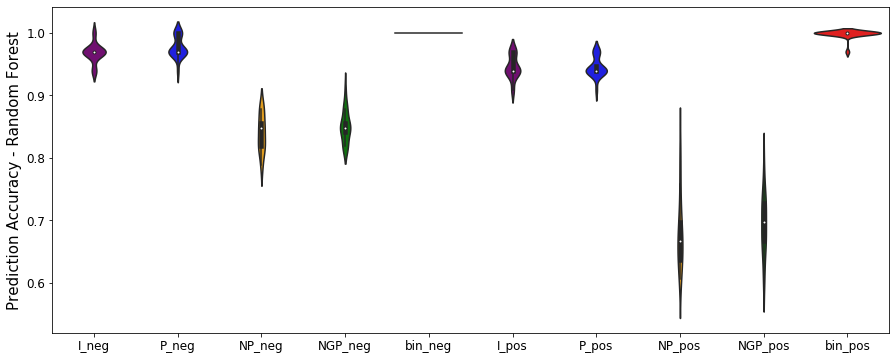

In [89]:
f, ax = plt.subplots(figsize=(15,6))
data = pd.DataFrame.from_dict(Teste)
colors = ['purple','blue','orange','green','red']
sns.violinplot( data = data.iloc[:,:10], palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - Random Forest', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize = 12)
print('Accuracy based on the dataset')

Accuracy based on the dataset


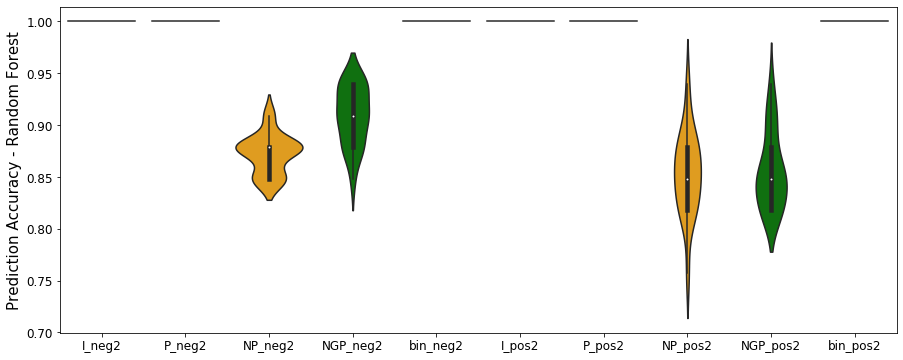

In [90]:
f, ax = plt.subplots(figsize=(15,6))
colors = ['purple','blue','orange','green','red']
sns.violinplot( data = data.iloc[:,10:], palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - Random Forest', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize = 12)
print('Accuracy based on the dataset')

In [91]:
#Here is median
Teste_A = {}
for i in Teste:
    Teste_A[i] = np.median(Teste[i])

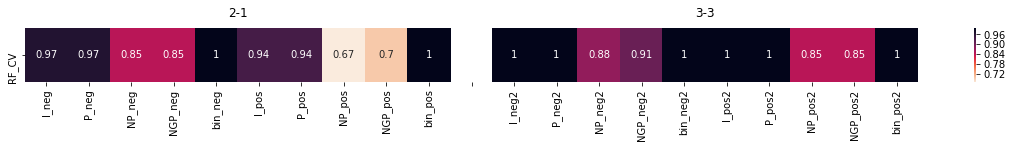

In [92]:
Teste_H = pd.DataFrame(list(Teste_A.values()), index = Teste_A.keys()).T
#Inserting blank lines in the DataFrame for better presentation and separation
Teste_H = pd.concat([Teste_H.iloc[:,:10], pd.DataFrame(np.empty((1,1))* np.nan, index = ['']).T, Teste_H.iloc[:,10:]], axis = 1)
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(Teste_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV'])
plt.text(5,-0.2,'2-1', fontsize  = 12, horizontalalignment='center')
plt.text(16,-0.2,'3-3', fontsize  = 12, horizontalalignment='center')
plt.show()

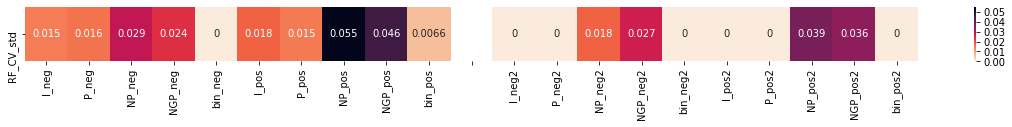

In [93]:
Teste_std_H = pd.DataFrame(list(Teste_std.values()), index = Teste.keys()).T
#Inserting blank lines in the DataFrame for better presentation and separation
Teste_std_H = pd.concat([Teste_std_H.iloc[:,:10], pd.DataFrame(np.empty((1,1))* np.nan, index = ['']).T, Teste_std_H.iloc[:,10:]], 
                        axis = 1)
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(Teste_std_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_std'])

In [94]:
Teste_H = pd.DataFrame(list(Teste_A.values()), index = Teste_A.keys(), columns = ['Accuracy']).T
Teste_std_H = pd.DataFrame(list(Teste_std.values()), index = Teste.keys()).T
#Teste_ic = Teste_std_H / (100**0.5)*1.96

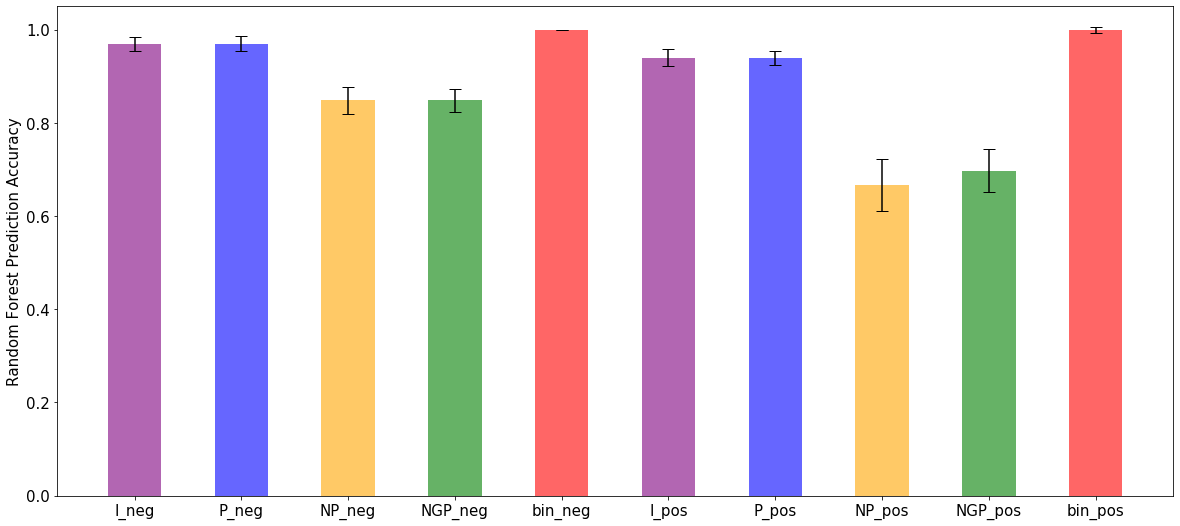

In [95]:
#sns.set_context('notebook')
f, ax = plt.subplots(figsize=(20, 9))

color = ['purple','blue','orange','green','red']
plt.bar(height = Teste_H.T['Accuracy'][0:10], x = Teste_H.columns[0:10], width = 0.5, color = color, alpha = 0.6)
ax.errorbar(x = Teste_H.columns[0:10], y = Teste_H.T['Accuracy'][0:10], yerr = Teste_std_H.iloc[0,:10], 
            ls = 'none', ecolor = 'black', capsize = 6)
plt.ylim(0,1.05)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Random Forest Prediction Accuracy', fontsize = 15)
plt.show() #This is with median

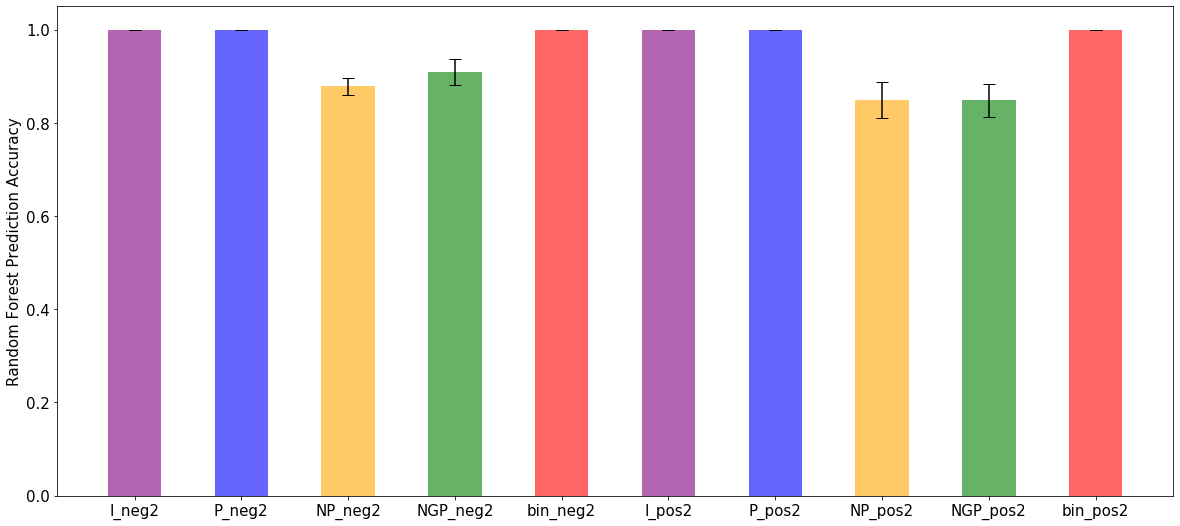

In [96]:
f, ax = plt.subplots(figsize=(20, 9))

color = ['purple','blue','orange','green','red']
plt.bar(height = Teste_H.T['Accuracy'][10:], x = Teste_H.columns[10:], width = 0.5, color = color, alpha = 0.6)
ax.errorbar(x = Teste_H.columns[10:], y = Teste_H.T['Accuracy'][10:], yerr = Teste_std_H.iloc[0,10:], 
            ls = 'none', ecolor = 'black', capsize = 6)
plt.ylim(0,1.05)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Random Forest Prediction Accuracy', fontsize = 15)
plt.show() #This is with median

#### Applications of different methods

### Attempt/Method nº1 - Direct

### Simple application of random forests

Since the dataset is small, the random forest classification is iterated n times to make sure more combinations of training and test samples are used. Then, an average of the results are obtained - number of random forests can be decided by iter_num. This is the same for all methods. 

To offset the small dataset, 3-fold Cross-Validation is used as an internal validation system evaluating the performance of the model based on its score/accuracy (3-fold since that is maximum number possible since every group of samples only has 3 replicates.

Besides the 3-fold cross-validation score, the order of the average of most important features across the random forests (with each iteration and group in cross-validation having the same weigth) is extracted from the forests "built".

Now to run the random forests on the different datasets (negative and positive of both alignments) both in their "normal" and "binary" matrices form. For the normal or euclidean matrices, only the data concerning the P data processing was used since it was the best performer of all former methods employed.

Application of the function `simple_RF` from multianalysis.

In [97]:
#Preparations of dicts:
Scores = {}
Scores_std = {}
Imp_feat = {}

In [98]:
part = {}

part['P_neg'] = treat_neg['P']
part['P_pos'] = treat_pos['P']
part['P_neg2'] = treat_neg2['P']
part['P_pos2'] = treat_pos2['P']
part['bin_neg'] = treat_neg['binary']
part['bin_pos'] = treat_pos['binary']
part['bin_neg2'] = treat_neg2['binary']
part['bin_pos2'] = treat_pos2['binary']

In [99]:
for name, data in part.items():
    print(f'Fitting random forest for {name} ...', end='')
    rf, imp_features = ma.simple_RF(data)#, iter_num = 100)
    Scores[name] = np.mean(rf)
    Scores_std[name] = np.std(rf)
    Imp_feat[name] = imp_features
    print(f'done') 

Fitting random forest for P_neg ...done
Fitting random forest for P_pos ...done
Fitting random forest for P_neg2 ...done
Fitting random forest for P_pos2 ...done
Fitting random forest for bin_neg ...done
Fitting random forest for bin_pos ...done
Fitting random forest for bin_neg2 ...done
Fitting random forest for bin_pos2 ...done


### Attempt/Method nº2 - SMOTE

### Oversampling data with SMOTE before splitting cross-validation groups. Expected better results due to bleed.

All the same specifications as method nº1 but with an oversampling of the data that doubles the amount of samples (from 39 to 78) which means each cross-valdiation group will have 2 replicates for each variety instead of one.

As mentioned in the title, this means there will be a "bleeding" of the data between test and training groups due to the samples in the test group having been originated from the ones in the training group or have been used to originate data in training groups. Therefore, the score of this method should be higher than the other due to an overestimation of how good the model is due to this bleeding.

SMOTE oversampling is performed in the initial imputated data by the function `fast_SMOTE` from multianalysis.py. 

Therefore we have to run the NGP data processing again for each dataset.

### Attempt/Method nº3 - Afterproc (Euclidean); Aftersplit (Binary)
Oversampling data with SMOTE after splitting data and after treatment of data (NGP) (binary matrixes don't have any further processing) - Problem: SMOTE after data processing isn't quite the same as in the beginning of the data (vectors between transformed data in different scale than original)

All the same specifications as method nº1.

#### Still possible although probably not very useful, as for now, it won't be implemented in the notebook (method nº4 is the same but completely excised of the notebook.

Application of the function `RF_M3` from multianalysis.

### Results of the Random Forests surmised in Heatmaps

In [100]:
Scores_H = pd.DataFrame(list(Scores.values()), index = Scores.keys()).T
Scores_std_H = pd.DataFrame(list(Scores_std.values()), index = Scores_std.keys()).T

#Inserting blank lines in the DataFrame for better presentation and separation
#Scores_H = pd.concat([Scores_H.iloc[:,:8], pd.DataFrame(np.empty((1,1))* np.nan, index = ['']).T, Scores_H.iloc[:,8:]], axis = 1)
#Scores_std_H = pd.concat([Scores_std_H.iloc[:,:8], pd.DataFrame(np.empty((1,1))* np.nan, index = ['']).T, Scores_std_H.iloc[:,8:]], 
                        #axis = 1)

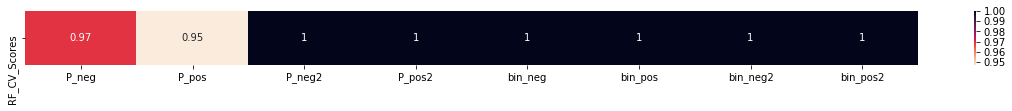

In [101]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(Scores_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_Scores'])
plt.show()

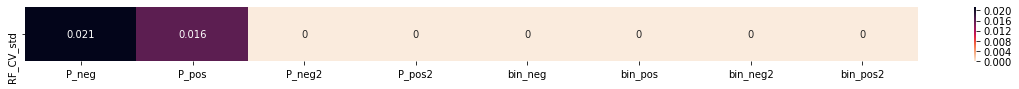

In [102]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(Scores_std_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_std'])

### Characteristics of the features seen as important in the different alignments, data treatments and modes (negative and positive) - Still mean, not median

We take the 2% most important features in each case and calculate the average number of samples those features appear (samples_m), the average number of different groups/varieties those features appear in (groups_n) and the ratio between these two measures (ratio_m, has a maximum of 3). We also see how many times the importance of the most importante feature is greater than the average importance of a feature in each case ('magni') as well as the % of the model explained (that use) the 2% of the most important features ('more').

A swarmplot is also built to see the distributions of the number of samples each important feature in each method appears to see their overall distribution.

### Alignments 2-1 and 3-3 (Bias)

In [103]:
#Getting the number of samples, groups, ratios for each important feature, 
#magnitude for most important feature and calculating % explained by these features (more)
ev = []
magni = []
more = []
for name in Teste_feat:#['neg2-1_direct']:
    if name.endswith('neg'):
        #continue
        Spectra = aligned_all_neg
    elif name.endswith('pos'):
        #continue
        Spectra = aligned_all_pos
    elif name.endswith('neg2'):
        #continue
        Spectra = aligned_all_neg2
    elif name.endswith('pos2'):
        #continue
        Spectra = aligned_all_pos2
        
    imp_features = Teste_feat[name]
    
    ratio = []
    nsamples = []
    n_groups = []
    
    #Top 2%
    number = round(0.02*len(Spectra))
    magni.append(imp_features[0][1]/(1/len(Spectra)))
    
    a = 0
    for i in range(number): 
        a = a + imp_features[i][1]*100 
        ngroups = {}
        line = Spectra.loc[imp_features[i][2],:].notnull()
        nsamples.append(line.sum())
        for n in range(len(line)):
            if line[n] == True:
                ngroups[Spectra.cdl.labels[n]] = 1
        n_groups.append(sum(list((ngroups.values()))))
        ratio.append(nsamples[-1]/n_groups[-1])
    more.append(a)
    df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
    df['nsamples'] = nsamples
    df['n_groups'] = n_groups
    df['ratio']  = ratio
    ev.append(df)
#print(ev[4])

In [104]:
#Calculating averages of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []
for i in range(len(ev)):
    samples_m.append(np.mean(ev[i].iloc[:,0]))
    groups_m.append(np.mean(ev[i].iloc[:,1]))
    ratio_m.append(np.mean(ev[i].iloc[:,2]))
df = pd.DataFrame(columns = ['samples_m', 'groups_m', 'ratio_m'], index = [i  for i in Teste_feat]) #if '2-1' in i])
df['samples_m'] = samples_m
df['groups_m'] = groups_m
df['ratio_m'] = ratio_m
#print(df)
#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame({"samples_m": None, "groups_m": None, 'ratio_m':None}, index=[''])
df = pd.concat([df.iloc[:5], line, df.iloc[5:10], line, df.iloc[10:15], line, df.iloc[15:]])

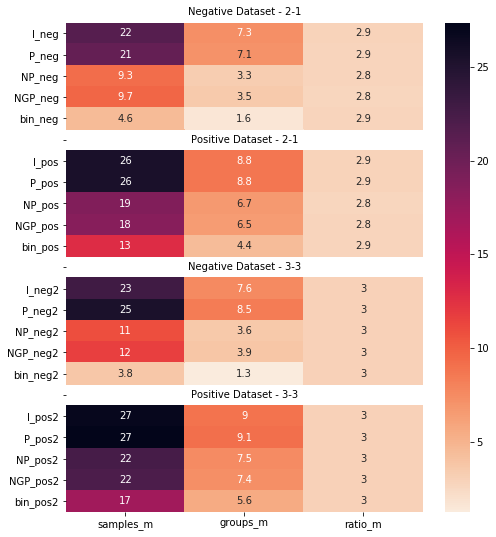

In [105]:
f, ax = plt.subplots(figsize=(8, 9))
hm = sns.heatmap(df, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(1.5,-0.5,'Negative Dataset - 2-1',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,5.5,'Positive Dataset - 2-1',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,11.5,'Negative Dataset - 3-3',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,17.5,'Positive Dataset - 3-3',horizontalalignment='center', verticalalignment='center')
plt.show()

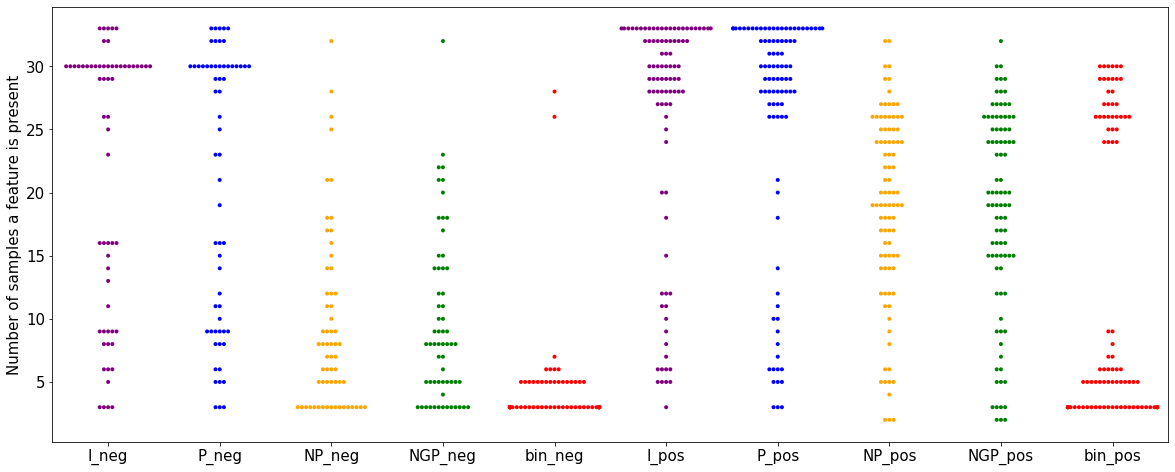

In [106]:
f, ax = plt.subplots(figsize=(20,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]
#print(data)
#sns.violinplot(data=data)
sns.swarmplot(data=data[:10], size = 4, palette = ['purple','blue','orange','green','red']*2)
ax.set(xticklabels = [list(Teste_feat.keys())[i][0:13] for i in range(len(Teste_feat.keys()))][:10])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.show()

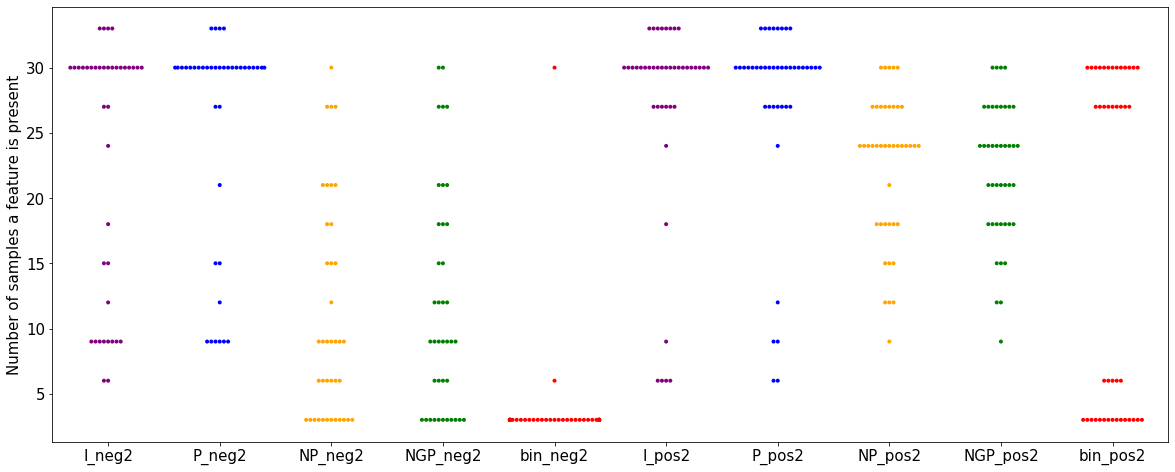

In [107]:
f, ax = plt.subplots(figsize=(20,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]
#print(data)
#sns.violinplot(data=data)
sns.swarmplot(data=data[10:], size = 4, palette = ['purple','blue','orange','green','red']*2)
ax.set(xticklabels = [list(Teste_feat.keys())[i][0:13] for i in range(len(Teste_feat.keys()))][10:])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.show()

In [108]:
print('Magnitude of most important feature:', )
for i in range(20):
    print(list(Teste_feat.keys())[i], '     \t', magni[i])
    
print('\n')
print('% of model explained by the 2% most important features')
for i in range(20):
    print(list(Teste_feat.keys())[i], '     \t', more[i])

Magnitude of most important feature:
I_neg      	 3.855841107299909
P_neg      	 4.141956521245747
NP_neg      	 3.175999018527578
NGP_neg      	 3.175182959022609
bin_neg      	 4.977703706843197
I_pos      	 8.176155588933097
P_pos      	 7.674609162222255
NP_pos      	 6.772280544987823
NGP_pos      	 6.779003907367452
bin_pos      	 7.205420824437303
I_neg2      	 3.6223383243081617
P_neg2      	 3.4580835812833124
NP_neg2      	 2.7802120670517323
NGP_neg2      	 2.3531220582940997
bin_neg2      	 3.647688416557043
I_pos2      	 5.561815063134194
P_pos2      	 5.784716129882378
NP_pos2      	 4.258022983520749
NGP_pos2      	 4.706711091644179
bin_pos2      	 5.203747174649648


% of model explained by the 2% most important features
I_neg      	 6.082192582365484
P_neg      	 6.188403891113778
NP_neg      	 4.606165670015719
NGP_neg      	 4.690742053592462
bin_neg      	 6.6402908253662805
I_pos      	 11.000505009805162
P_pos      	 10.9504418959293
NP_pos      	 8.0275013573812

### PLS-DA - Classification based on Partial Least Squares - Discriminant Analysis

Creating the target vectors matrix where each different group is made into a column and 1 represents the sample belongs to that group (0 means it doesn't belong).

In [109]:
# Centralize data again excluding the not Imp / Ionly data
datasets = {}

datasets['P_neg'] = treat_neg['P']
datasets['NP_neg'] = treat_neg['NP']
datasets['NGP_neg'] = treat_neg['NGP']
datasets['bin_neg'] = treat_neg['binary']

datasets['P_pos'] = treat_pos['P']
datasets['NP_pos'] = treat_pos['NP']
datasets['NGP_pos'] = treat_pos['NGP']
datasets['bin_pos'] = treat_pos['binary']

datasets['P_neg2'] = treat_neg2['P']
datasets['NP_neg2'] = treat_neg2['NP']
datasets['NGP_neg2'] = treat_neg2['NGP']
datasets['bin_neg2'] = treat_neg2['binary']

datasets['P_pos2'] = treat_pos2['P']
datasets['NP_pos2'] = treat_pos2['NP']
datasets['NGP_pos2'] = treat_pos2['NGP']
datasets['bin_pos2'] = treat_pos2['binary']

### Search for the best number of components to use - Alignment 2-1 and 3-3

Strategy: Perform PLS-DA with different number of components and observe the score (both given directly by the method and the r2 score) and the mean-squared error (MSE) of the models built with 3-fold cross-validation (3 was chosen since it is the max for our dataset - 3 replicates in each group, having an added bonus of still maintaining a balanced dataset). Then plot the different results obtained and see at which point (number of components) the score and the MSE stops start approaching a "stable value".

The maximum number of components tested was 50 (which was enough for the objective established above).

Warnings are due to the type of scoring that will be changed in the next version of scikit learn.

Function `optim_PLS` in multianalysis.py - performs PLS analysis and obtains the results stated above with number of components defined from 1 to max_comp.

In [110]:
PLS_optim = {}

In [111]:
%%capture --no-stdout
for name, data in datasets.items():
    print(f'Optimizing PLS-DA for {name} ...', end='')
    CVs, CVr2s, MSEs = ma.optim_PLS(data, max_comp = 50)
    PLS_optim[name] = CVs
    print(f'done')    

Optimizing PLS-DA for P_neg ...done
Optimizing PLS-DA for NP_neg ...done
Optimizing PLS-DA for NGP_neg ...done
Optimizing PLS-DA for bin_neg ...done
Optimizing PLS-DA for P_pos ...done
Optimizing PLS-DA for NP_pos ...done
Optimizing PLS-DA for NGP_pos ...done
Optimizing PLS-DA for bin_pos ...done
Optimizing PLS-DA for P_neg2 ...done
Optimizing PLS-DA for NP_neg2 ...done
Optimizing PLS-DA for NGP_neg2 ...done
Optimizing PLS-DA for bin_neg2 ...done
Optimizing PLS-DA for P_pos2 ...done
Optimizing PLS-DA for NP_pos2 ...done
Optimizing PLS-DA for NGP_pos2 ...done
Optimizing PLS-DA for bin_pos2 ...done


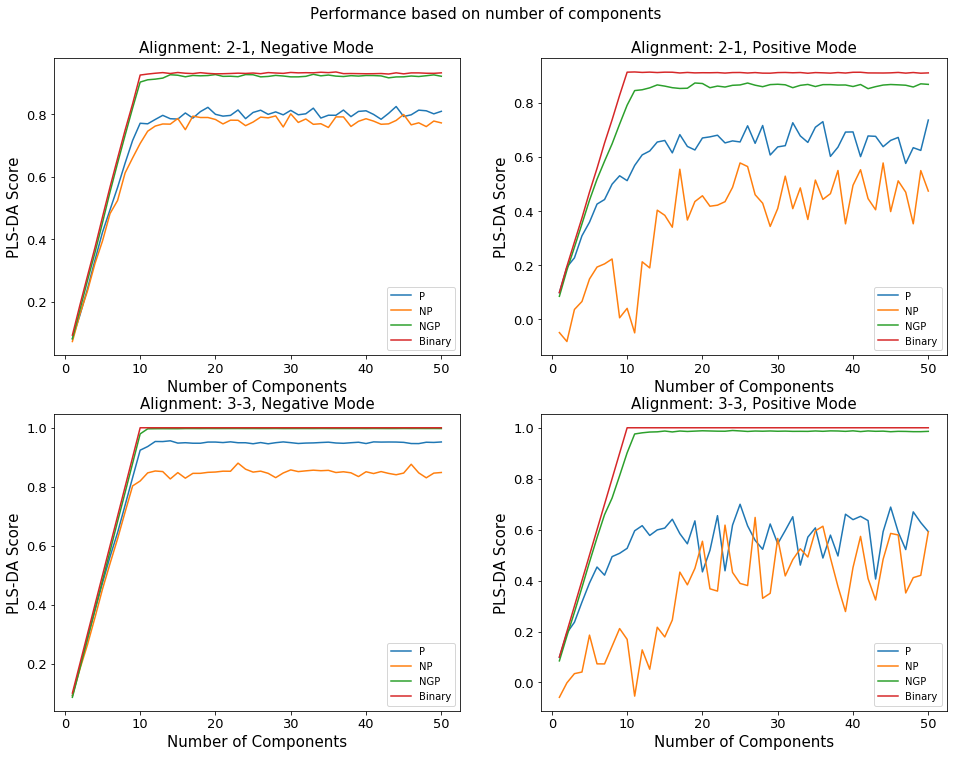

In [112]:
f, axes = plt.subplots(2, 2, figsize = (16,12))
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
plt.suptitle('Performance based on number of components', fontsize = 15, x = 0.5, y = 0.94)

for name, data in PLS_optim.items():
    if name.endswith('neg'):
        quadrant[0].plot(range(1,51),data)
        quadrant[0].set_xlabel('Number of Components', fontsize=15)
        quadrant[0].set_ylabel('PLS-DA Score', fontsize=15)
        quadrant[0].set_title('Alignment: 2-1, Negative Mode', fontsize=15)
        quadrant[0].tick_params(axis='both', which='major', labelsize=13)
        quadrant[0].legend(('P', 'NP', 'NGP', 'Binary'))
    if name.endswith('pos'):
        quadrant[1].plot(range(1,51),data)
        quadrant[1].set_xlabel('Number of Components', fontsize=15)
        quadrant[1].set_ylabel('PLS-DA Score', fontsize=15)
        quadrant[1].set_title('Alignment: 2-1, Positive Mode', fontsize=15)
        quadrant[1].tick_params(axis='both', which='major', labelsize=13)
        quadrant[1].legend(('P', 'NP', 'NGP', 'Binary'))
    if name.endswith('neg2'):
        quadrant[2].plot(range(1,51),data)
        quadrant[2].set_xlabel('Number of Components', fontsize=15)
        quadrant[2].set_ylabel('PLS-DA Score', fontsize=15)
        quadrant[2].set_title('Alignment: 3-3, Negative Mode', fontsize=15)
        quadrant[2].tick_params(axis='both', which='major', labelsize=13)
        quadrant[2].legend(('P', 'NP', 'NGP', 'Binary'))
    if name.endswith('pos2'):
        quadrant[3].plot(range(1,51),data)
        quadrant[3].set_xlabel('Number of Components', fontsize=15)
        quadrant[3].set_ylabel('PLS-DA Score', fontsize=15)
        quadrant[3].set_title('Alignment: 3-3, Positive Mode', fontsize=15)
        quadrant[3].tick_params(axis='both', which='major', labelsize=13)
        quadrant[3].legend(('P', 'NP', 'NGP', 'Binary'))

### Application of PLS-DA

The number of components where the evaluating metrics stopped getting considerably better when it reached around 15. 

We can now transform the PLS algorithm (PLS2 algorithm used) to give classification of samples instead of regression using a decision rule to interpret the y_pred result given for each test sample and decide what group it belongs to. In this case a simple rule of the group with the highest number (closer to 1) is decided to be the group to which said sample belongs to - naive MAX rule.

Two metrics to evaluate the results were evaluated. First the score of the model as seen before but more importantly the second one is the accuracy of the model based on the decision rule stated above. All samples are tested once in 3 different groups as 3-fold cross-validation.

In [113]:
PLS_accu = {}
PLS_score = {}
PLS_feat = {}

In [114]:
%%capture --no-stdout
for name, data in datasets.items():
    print(f'Fitting PLS-DA for {name} ...', end='')
    accu, score, u, imp_features = ma.model_PLSDA(data, n_comp = 15, iter_num = 100, feat_type = 'Coef')
    PLS_accu[name] = accu
    PLS_score[name] = score
    PLS_feat[name] = imp_features
    print(f'done')    

Fitting PLS-DA for P_neg ...done
Fitting PLS-DA for NP_neg ...done
Fitting PLS-DA for NGP_neg ...done
Fitting PLS-DA for bin_neg ...done
Fitting PLS-DA for P_pos ...done
Fitting PLS-DA for NP_pos ...done
Fitting PLS-DA for NGP_pos ...done
Fitting PLS-DA for bin_pos ...done
Fitting PLS-DA for P_neg2 ...done
Fitting PLS-DA for NP_neg2 ...done
Fitting PLS-DA for NGP_neg2 ...done
Fitting PLS-DA for bin_neg2 ...done
Fitting PLS-DA for P_pos2 ...done
Fitting PLS-DA for NP_pos2 ...done
Fitting PLS-DA for NGP_pos2 ...done
Fitting PLS-DA for bin_pos2 ...done


### Alignment 2-1

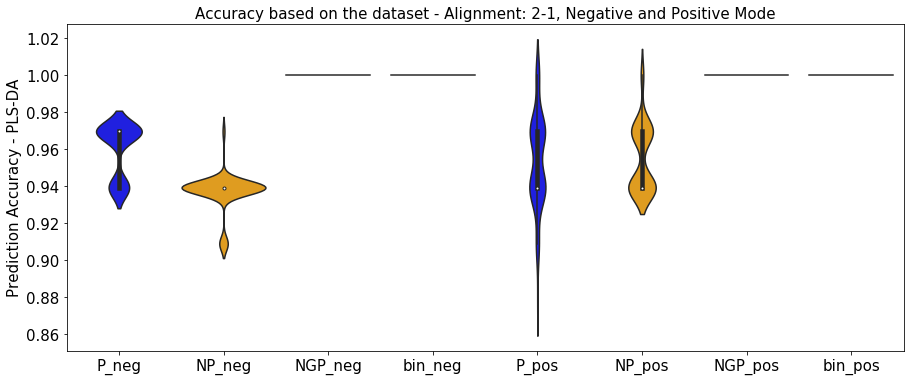

In [115]:
f, ax = plt.subplots(figsize=(15,6))
colors = ['blue','orange','green','red']
data=pd.DataFrame.from_dict(PLS_accu).iloc[:,:8]
sns.violinplot(data=data, palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - PLS-DA', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize= 15)
plt.title('Accuracy based on the dataset - Alignment: 2-1, Negative and Positive Mode', fontsize = 15)
plt.show()

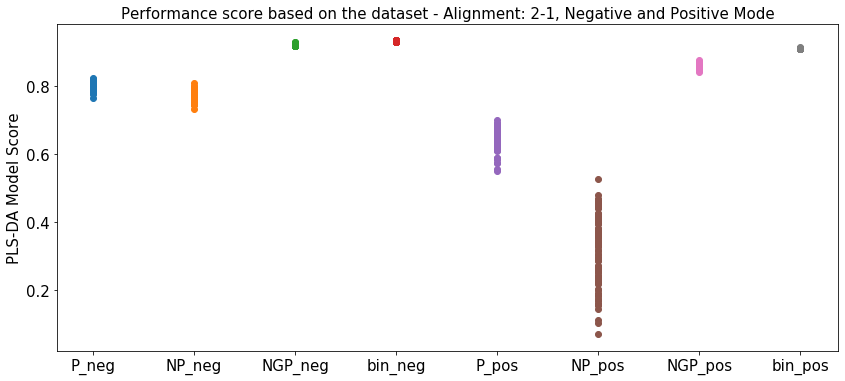

In [116]:
f, ax = plt.subplots(figsize=(14,6))
for name, data in PLS_score.items():
    if not name.endswith('2'):
        plt.scatter([name]*len(data), data)
plt.ylabel('PLS-DA Model Score', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.title('Performance score based on the dataset - Alignment: 2-1, Negative and Positive Mode', fontsize = 15)
plt.show()

### Alignment 3-3

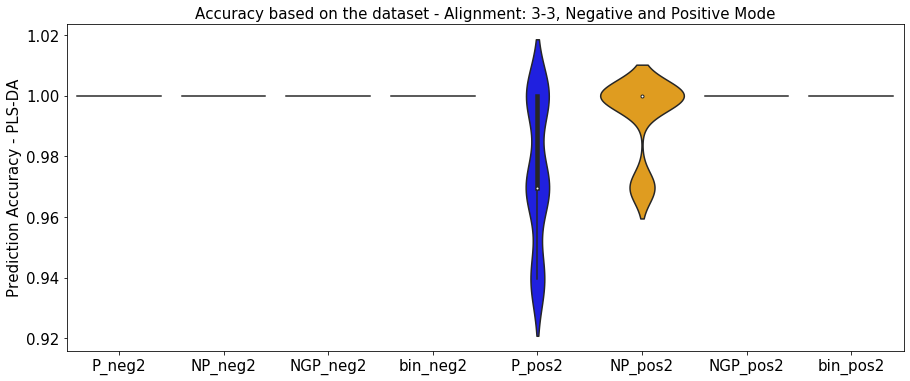

In [117]:
f, ax = plt.subplots(figsize=(15,6))
colors = ['blue','orange','green','red']
data=pd.DataFrame.from_dict(PLS_accu).iloc[:,8:]
sns.violinplot(data=data, palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - PLS-DA', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize= 15)
plt.title('Accuracy based on the dataset - Alignment: 3-3, Negative and Positive Mode', fontsize = 15)
plt.show()

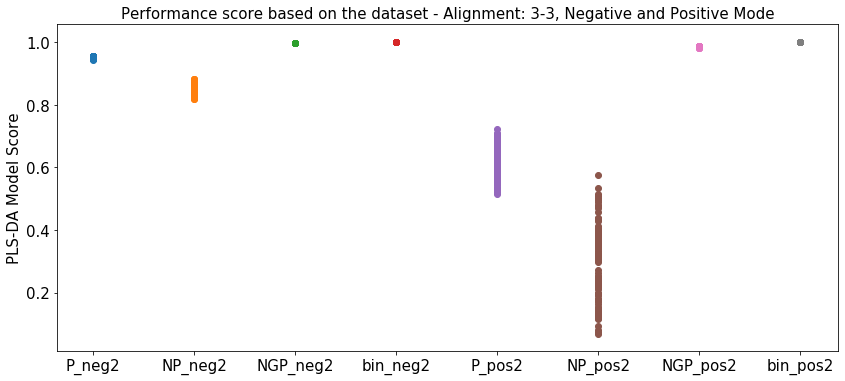

In [118]:
f, ax = plt.subplots(figsize=(14,6))
for name, data in PLS_score.items():
    if name.endswith('2'):
        plt.scatter([name]*len(data), data)
plt.ylabel('PLS-DA Model Score', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.title('Performance score based on the dataset - Alignment: 3-3, Negative and Positive Mode', fontsize = 15)
plt.show()

### Accuracies and Scores Summary - With Medians but also still with standard deviations

In [119]:
Accuracy = {}
Score = {}
Accuracy_std = {}
Score_std = {}
for name in PLS_score.keys():
    Accuracy[name] = np.median(PLS_accu[name])
    Score[name] = np.median(PLS_score[name])
    
    Accuracy_std[name] = np.std(PLS_accu[name])
    Score_std[name] = np.std(PLS_score[name])

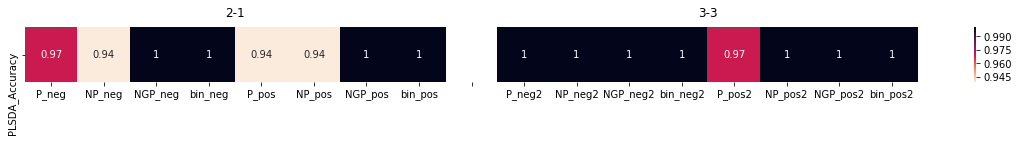

In [120]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys()).T
#Inserting blank lines in the DataFrame for better presentation and separation
Accuracy_H = pd.concat([Accuracy_H.iloc[:,:8], pd.DataFrame(np.empty((1,1))* np.nan, index = ['']).T, Accuracy_H.iloc[:,8:]], axis = 1)

f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(Accuracy_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Accuracy'])

plt.text(4,-0.2,'2-1', fontsize  = 12, horizontalalignment='center')
plt.text(13,-0.2,'3-3', fontsize  = 12, horizontalalignment='center')
plt.show()

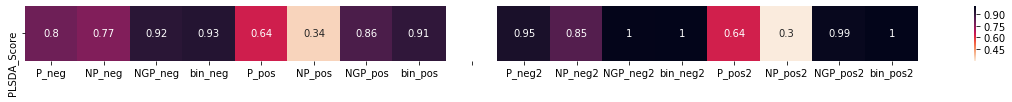

In [121]:
Score_H = pd.DataFrame(list(Score.values()), index = Score.keys()).T
#Inserting blank lines in the DataFrame for better presentation and separation
Score_H = pd.concat([Score_H.iloc[:,:8], pd.DataFrame(np.empty((1,1))* np.nan, index = ['']).T, Score_H.iloc[:,8:]], axis = 1)

f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(Score_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Score'])

In [122]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys(), columns  = ['Accuracy']).T
Accuracy_H.loc['SD'] = list(Accuracy_std.values())
Accuracy_H.T

,Accuracy,SD
P_neg,0.969697,0.014015
NP_neg,0.939394,0.009824
NGP_neg,1.000000,0.000000
bin_neg,1.000000,0.000000
P_pos,0.939394,0.024424
NP_pos,0.939394,0.017917
NGP_pos,1.000000,0.000000
bin_pos,1.000000,0.000000
P_neg2,1.000000,0.000000
NP_neg2,1.000000,0.000000


In [123]:
Score_H = pd.DataFrame(list(Score.values()), index = Score.keys(), columns  = ['Score']).T
Score_H.loc['SD'] = list(Score_std.values())
Score_H.T

,Score,SD
P_neg,0.801625,0.010927
NP_neg,0.770842,0.014429
NGP_neg,0.923392,0.002108
bin_neg,0.933197,0.001426
P_pos,0.642188,0.030226
NP_pos,0.344501,0.096478
NGP_pos,0.860941,0.005645
bin_pos,0.911670,0.000956
P_neg2,0.952130,0.002483
NP_neg2,0.845706,0.015573


### Characteristics of the most important features - still mean (not median)

The characteristics of the most important features for each of the methods is done by the same process as applied in the random forests section of the notebook.

In [124]:
#Getting the number of samples, groups, ratios for each important feature, magnitude for most important feature 
ev = []
magni = []
index = []

for name in PLS_feat:
    if name.endswith('neg'):
        Spectra = aligned_all_neg
    elif name.endswith('pos'):
        Spectra = aligned_all_pos
    elif name.endswith('neg2'):
        Spectra = aligned_all_neg2
    elif name.endswith('pos2'):
        Spectra = aligned_all_pos2
    
    imp_features = PLS_feat[name]
    
    index.append(name)
    ratio = []
    nsamples = []
    n_groups = []
    
    #Top 2%
    number = round(0.02*len(Spectra))
    total_m = 0
    
    for i in range(len(imp_features)):
        total_m = total_m + imp_features[i][1]
    magni.append(imp_features[0][1]/(total_m/len(Spectra)))
    for i in range(number): 
        ngroups = {}
        line = Spectra.loc[imp_features[i][2],:].notnull()
        nsamples.append(line.sum())
        for n in range(len(line)):
            if line[n] == True:
                ngroups[Spectra.cdl.labels[n]] = 1
        n_groups.append(sum(list((ngroups.values()))))
        ratio.append(nsamples[-1]/n_groups[-1])
    df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
    df['nsamples'] = nsamples
    df['n_groups'] = n_groups
    df['ratio']  = ratio
    ev.append(df)

In [125]:
#Calculating averages of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []
for i in range(len(ev)):
    samples_m.append(np.mean(ev[i].iloc[:,0]))
    groups_m.append(np.mean(ev[i].iloc[:,1]))
    ratio_m.append(np.mean(ev[i].iloc[:,2]))
df = pd.DataFrame(columns = ['samples_m', 'groups_m', 'ratio_m'], index = index)
df['samples_m'] = samples_m
df['groups_m'] = groups_m
df['ratio_m'] = ratio_m
#print(df)
#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame({"samples_m": None, "groups_m": None, 'ratio_m':None}, index=[''])
df = pd.concat([df.iloc[:4], line, df.iloc[4:8], line, df.iloc[8:12], line, df.iloc[12:]])

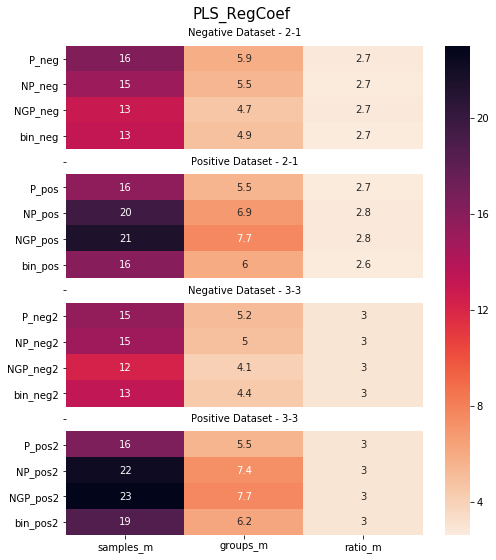

In [126]:
f, ax = plt.subplots(figsize=(8, 9))
hm = sns.heatmap(df, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.suptitle('PLS_RegCoef', fontsize = 15, x = 0.43, y = 0.94)
plt.text(1.5,-0.5,'Negative Dataset - 2-1',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,4.5,'Positive Dataset - 2-1',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,9.5,'Negative Dataset - 3-3',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,14.5,'Positive Dataset - 3-3',horizontalalignment='center', verticalalignment='center')
plt.show()

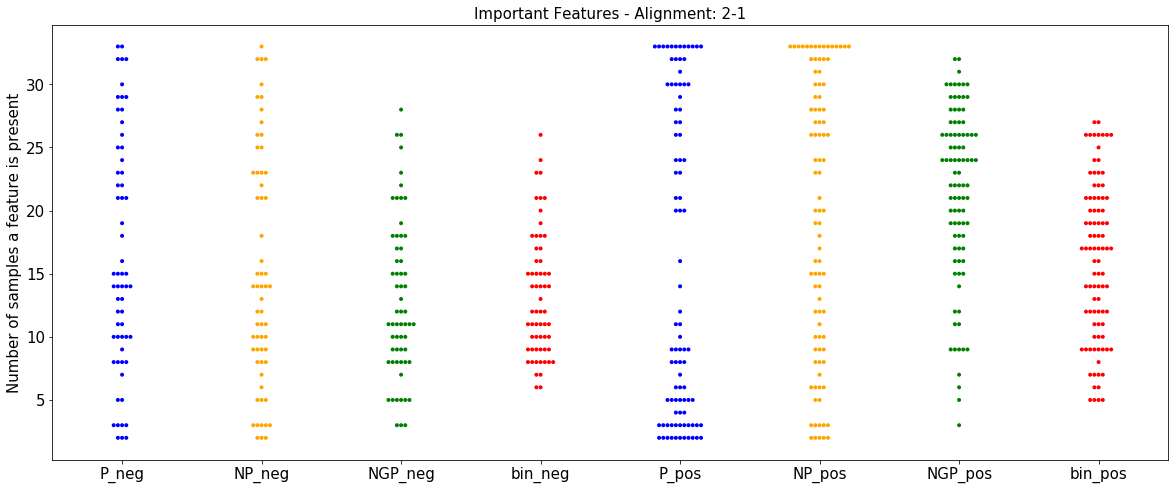

In [127]:
f, ax = plt.subplots(figsize=(20,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]
#sns.violinplot(data=data)
sns.swarmplot(data=data[:8], size = 4, palette = ['blue','orange','green','red']*2)
ax.set(xticklabels = [list(PLS_feat.keys())[i] for i in range(len(PLS_feat.keys()))])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.title('Important Features - Alignment: 2-1', fontsize = 15)
plt.show()

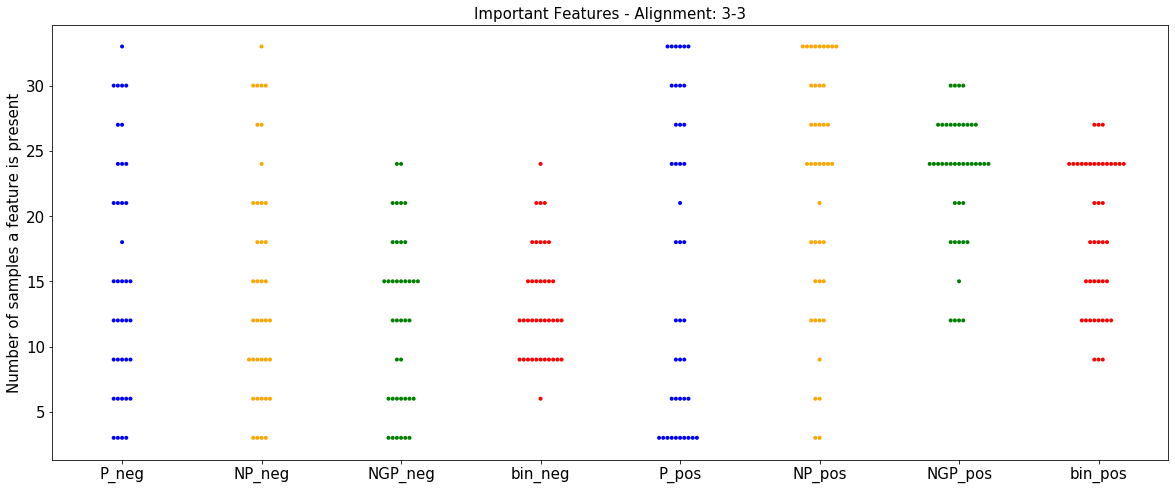

In [128]:
f, ax = plt.subplots(figsize=(20,8))
#sns.violinplot(data=data)
sns.swarmplot(data=data[8:], size = 4, palette = ['blue','orange','green','red']*2)
ax.set(xticklabels = [list(PLS_feat.keys())[i] for i in range(len(PLS_feat.keys()))])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.title('Important Features - Alignment: 3-3', fontsize = 15)
plt.show()

In [129]:
print('Magnitude of most important features for each case:')
for i in range(16):
    print(list(PLS_feat.keys())[i], '     \t', magni[i])

Magnitude of most important features for each case:
P_neg      	 16.067260491143507
NP_neg      	 17.207853263899164
NGP_neg      	 4.6978777905383575
bin_neg      	 3.5038014618070523
P_pos      	 20.507575578123088
NP_pos      	 12.08202955250666
NGP_pos      	 7.754916939609537
bin_pos      	 5.378263810624749
P_neg2      	 15.115879121462909
NP_neg2      	 14.450040099612712
NGP_neg2      	 4.787983602746609
bin_neg2      	 3.266090731035829
P_pos2      	 13.728181368355326
NP_pos2      	 8.115762999845868
NGP_pos2      	 6.09611028089082
bin_pos2      	 4.93484349400631


### Example of models built with the full dataset and sample representation on the two most important Components/Latent Variables

In [130]:
def plot_PLSDA(principaldf, label_colors, components=(1,2), title="PLS-DA", ax=None):
    if ax is None:
        ax = plt.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    col_c1_name, col_c2_name = principaldf.columns[[loc_c1, loc_c2]]
    
    with sns.axes_style("whitegrid"):
        #ax.axis('equal')
        ax.set_xlabel(f'{col_c1_name}', fontsize = 15)
        ax.set_ylabel(f'{col_c2_name}', fontsize = 15)

        unique_labels = principaldf['Label'].unique()

        for lbl in unique_labels:
            subset = principaldf[principaldf['Label']==lbl]
            ax.scatter(subset[col_c1_name],
                       subset[col_c2_name],
                       s=50, color=label_colors[lbl], label=lbl)

        ax.legend(framealpha=1)
        ax.set_title(title, fontsize=15)

#### NGP data treatment for the Negative Mode - Alignment: 2-1

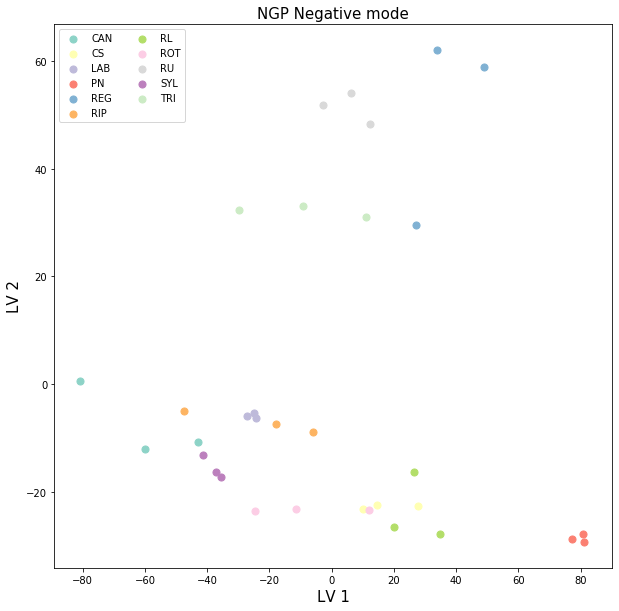

In [131]:
n_components = 15

plsreg_GPneg = ma.PLSscores_with_labels(NGP_neg, n_components)

fig, axl = plt.subplots(1,1, figsize=(10,10))
plot_PLSDA(plsreg_GPneg, label_colors, title="NGP Negative mode", ax=axl)
plt.legend(loc='upper left', ncol=2)
plt.show()

#### Binary processed data for the negative mode - Alignment: 2-1

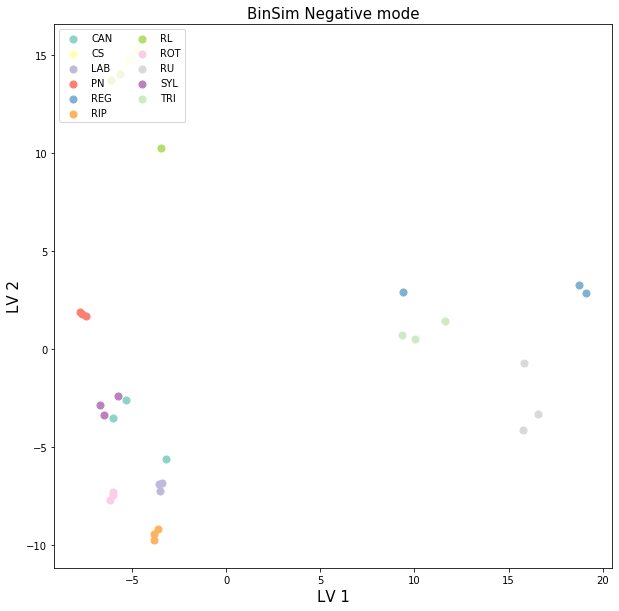

In [132]:
n_components = 15

plsreg_GPneg = ma.PLSscores_with_labels(aligned_neg, n_components)

fig, axl = plt.subplots(1,1, figsize=(10,10))
plot_PLSDA(plsreg_GPneg, label_colors, title="BinSim Negative mode", ax=axl)
plt.legend(loc='upper left', ncol=2)
plt.show()

#### NGP data treatment for the Negative Mode - Alignment: 3-3

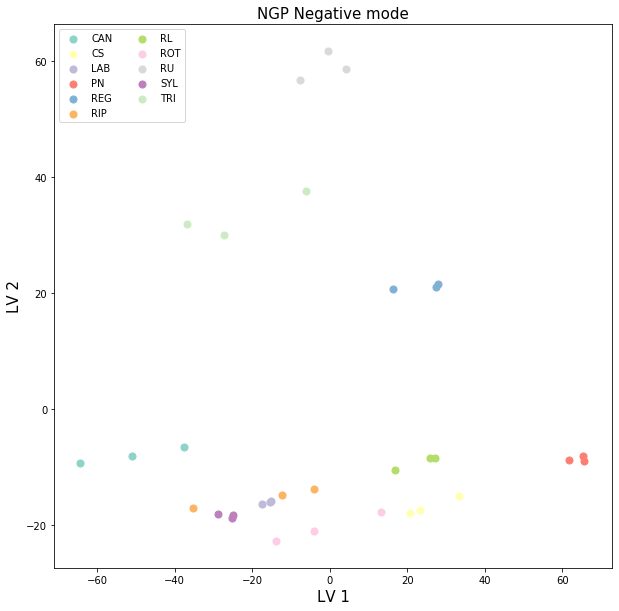

In [133]:
n_components = 15

plsreg_GPneg = ma.PLSscores_with_labels(NGP_neg2, n_components)

fig, axl = plt.subplots(1,1, figsize=(10,10))
plot_PLSDA(plsreg_GPneg, label_colors, title="NGP Negative mode", ax=axl)
plt.legend(loc='upper left', ncol=2)
plt.show()

#### Binary processed data for the negative mode - Alignment: 3-3

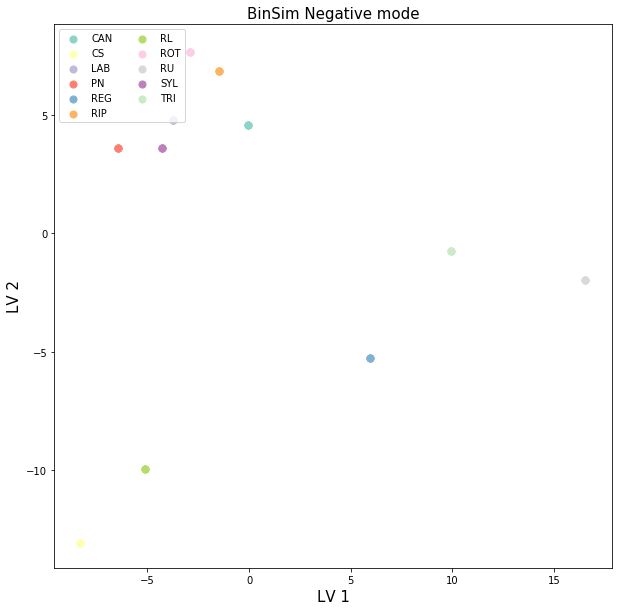

In [134]:
n_components = 10

plsreg_GPneg = ma.PLSscores_with_labels(aligned_neg2, n_components)

fig, axl = plt.subplots(1,1, figsize=(10,10))
plot_PLSDA(plsreg_GPneg, label_colors, title="BinSim Negative mode", ax=axl)
plt.legend(loc='upper left', ncol=2)
plt.show()

### Permutation Tests - Random Forests

Permutation tests is based on shuffling the labels of the different samples, shuflling the groups where they belong with the intent to see if the classifier tested, whether it is random forests or pls-da found a significant class structure in the data. 

For that a random 3-fold cross-validation is performed on the original dataset (to serve as a comparation point) and 150 permutations of datasets with labels randomly shuffled around with the model being evaluated by how good the predictions the model does of the test data is. 

Histograms with the prediction accuracy of the different permutations were plotted and compared to the accuracy got with the original dataset.

The empirical p-value is given by (the number of times the permutation accuracy was bigger than the random 3-fold cross-validation made with the original dataset + 1) / (number of permutations + 1) (source: Ojala2010 - error should be the opposite of the accuracy).

Use of function `permutation_RF` in multianalysis.py

In [135]:
CV = {}
PMs = {}
pvalue = {}

In [136]:
all_data = (P_neg, NP_neg, NGP_neg, aligned_neg, P_pos, NP_pos, NGP_pos, aligned_pos,
           P_neg2, NP_neg2, NGP_neg2, aligned_neg2, P_pos2, NP_pos2, NGP_pos2, aligned_pos2)
names = ('P_neg', 'NP_neg', 'NGP_neg', 'bin_neg', 'P_pos', 'NP_pos', 'NGP_pos', 'bin_pos',
        'P_neg2', 'NP_neg2', 'NGP_neg2', 'bin_neg2', 'P_pos2', 'NP_pos2', 'NGP_pos2', 'bin_pos2')

for name, data in zip(names, all_data):
    print(f'Permutation test (Random Forest) for {name} ...')
    permuta = ma.permutation_RF(data, iter_num=150, n_fold=3)
    CV[name] = permuta[0]
    PMs[name] = permuta[1]
    pvalue[name] = permuta[2]
    print('Done!')

Permutation test (Random Forest) for P_neg ...
Done!
Permutation test (Random Forest) for NP_neg ...
Done!
Permutation test (Random Forest) for NGP_neg ...
Done!
Permutation test (Random Forest) for bin_neg ...
Done!
Permutation test (Random Forest) for P_pos ...
Done!
Permutation test (Random Forest) for NP_pos ...
Done!
Permutation test (Random Forest) for NGP_pos ...
Done!
Permutation test (Random Forest) for bin_pos ...
Done!
Permutation test (Random Forest) for P_neg2 ...
Done!
Permutation test (Random Forest) for NP_neg2 ...
Done!
Permutation test (Random Forest) for NGP_neg2 ...
Done!
Permutation test (Random Forest) for bin_neg2 ...
Done!
Permutation test (Random Forest) for P_pos2 ...
Done!
Permutation test (Random Forest) for NP_pos2 ...
Done!
Permutation test (Random Forest) for NGP_pos2 ...
Done!
Permutation test (Random Forest) for bin_pos2 ...
Done!


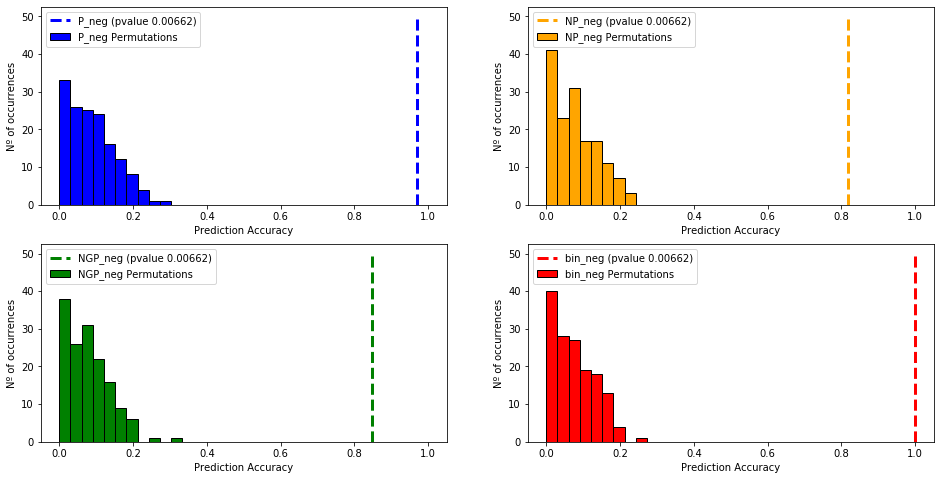

In [137]:
f, axes = plt.subplots(2, 2, figsize = (16,8))

Names = ['P_neg', 'NP_neg', 'NGP_neg', 'bin_neg']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_neg.cdl.labels)

#plt.suptitle('Permutation Tests - Random Forests')

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

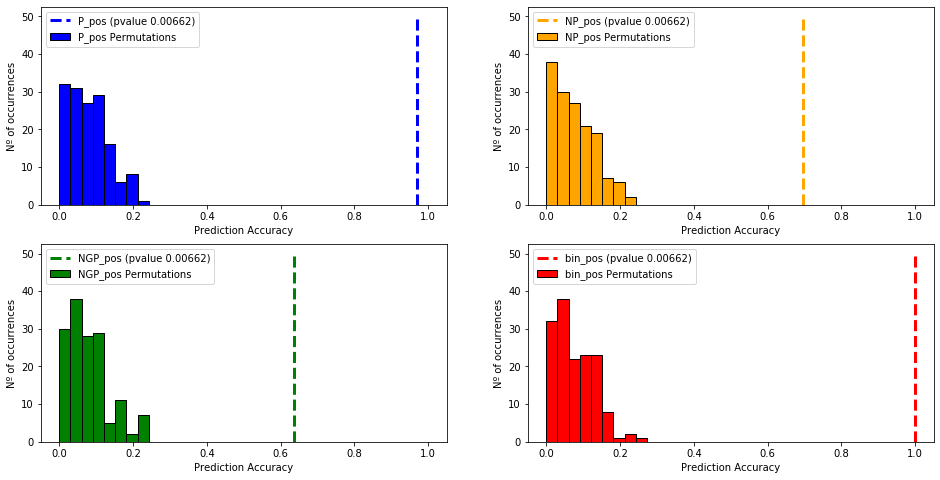

In [138]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_pos', 'NP_pos', 'NGP_pos', 'bin_pos']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_pos.cdl.labels)

#plt.suptitle('Permutation Tests - Random Forests')

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

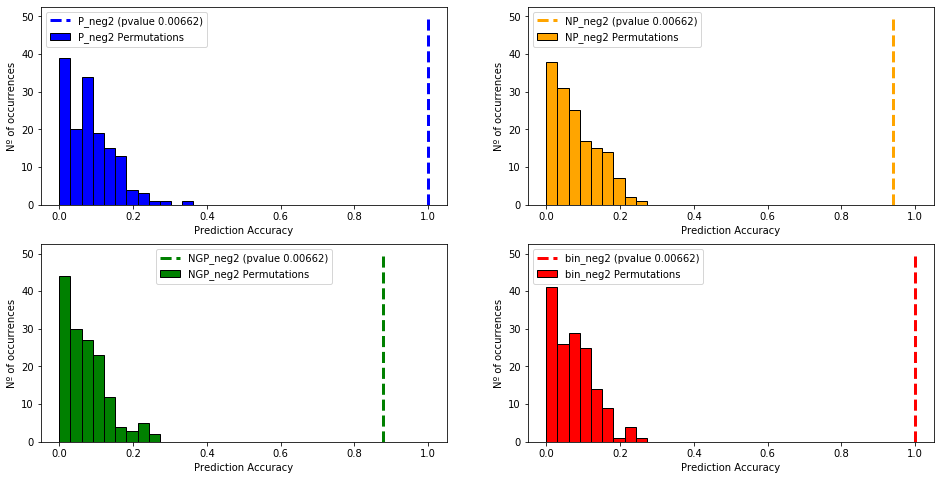

In [139]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_neg2', 'NP_neg2', 'NGP_neg2', 'bin_neg2']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_neg2.cdl.labels)

#plt.suptitle('Permutation Tests - Random Forests')

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

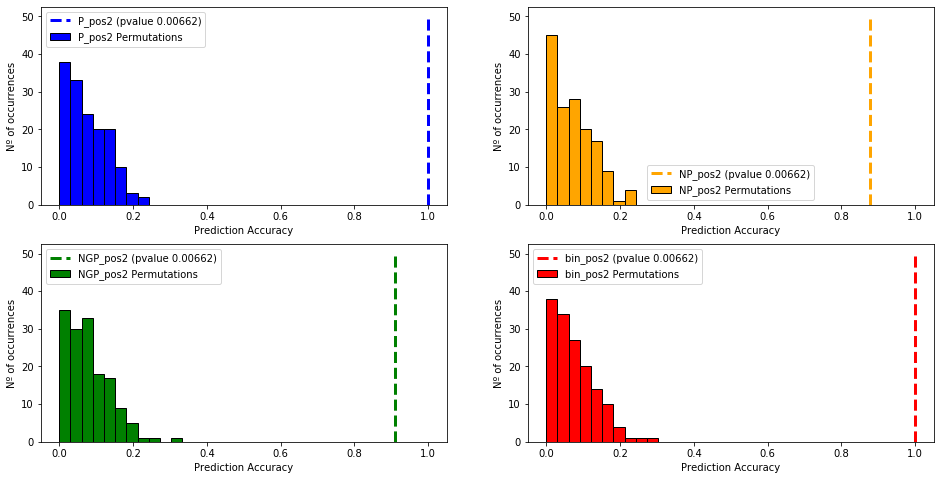

In [140]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_pos2', 'NP_pos2', 'NGP_pos2', 'bin_pos2']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_pos2.cdl.labels)

#plt.suptitle('Permutation Tests - Random Forests')

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

### Permutation Tests - PLS-DA

Same explanation as presented for Permutation Tests - Random Forests

In [141]:
CV_PLS = {}
PMs_PLS = {}
pvalue_PLS = {}

In [142]:
all_data = (P_neg, NP_neg, NGP_neg, aligned_neg, P_pos, NP_pos, NGP_pos, aligned_pos,
           P_neg2, NP_neg2, NGP_neg2, aligned_neg2, P_pos2, NP_pos2, NGP_pos2, aligned_pos2)
names = ('P_neg', 'NP_neg', 'NGP_neg', 'bin_neg', 'P_pos', 'NP_pos', 'NGP_pos', 'bin_pos',
        'P_neg2', 'NP_neg2', 'NGP_neg2', 'bin_neg2', 'P_pos2', 'NP_pos2', 'NGP_pos2', 'bin_pos2')

for name, data in zip(names, all_data):
    if name == 'bin_neg2':
        print(f'permutation test (PLS-DA) for {name} ...')
        permuta = ma.permutation_PLSDA(data, n_comp=7, iter_num=150)
        CV_PLS[name] = permuta[0]
        PMs_PLS[name] = permuta[1]
        pvalue_PLS[name] = permuta[2]
        print('Done!')
    elif name == 'bin_pos2':
        print(f'permutation test (PLS-DA) for {name} ...')
        permuta = ma.permutation_PLSDA(data, n_comp=7, iter_num=150)
        CV_PLS[name] = permuta[0]
        PMs_PLS[name] = permuta[1]
        pvalue_PLS[name] = permuta[2]
        print('Done!')
    else:
        print(f'permutation test (PLS-DA) for {name} ...')
        permuta = ma.permutation_PLSDA(data, n_comp=12, iter_num=150)
        CV_PLS[name] = permuta[0]
        PMs_PLS[name] = permuta[1]
        pvalue_PLS[name] = permuta[2]
        print('Done!')

permutation test (PLS-DA) for P_neg ...
Done!
permutation test (PLS-DA) for NP_neg ...
Done!
permutation test (PLS-DA) for NGP_neg ...
Done!
permutation test (PLS-DA) for bin_neg ...
Done!
permutation test (PLS-DA) for P_pos ...
Done!
permutation test (PLS-DA) for NP_pos ...
Done!
permutation test (PLS-DA) for NGP_pos ...


C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for bin_pos ...
Done!
permutation test (PLS-DA) for P_neg2 ...


C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for NP_neg2 ...
Done!
permutation test (PLS-DA) for NGP_neg2 ...


C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for bin_neg2 ...
Done!
permutation test (PLS-DA) for P_pos2 ...
Done!
permutation test (PLS-DA) for NP_pos2 ...
Done!
permutation test (PLS-DA) for NGP_pos2 ...
Done!
permutation test (PLS-DA) for bin_pos2 ...
Done!


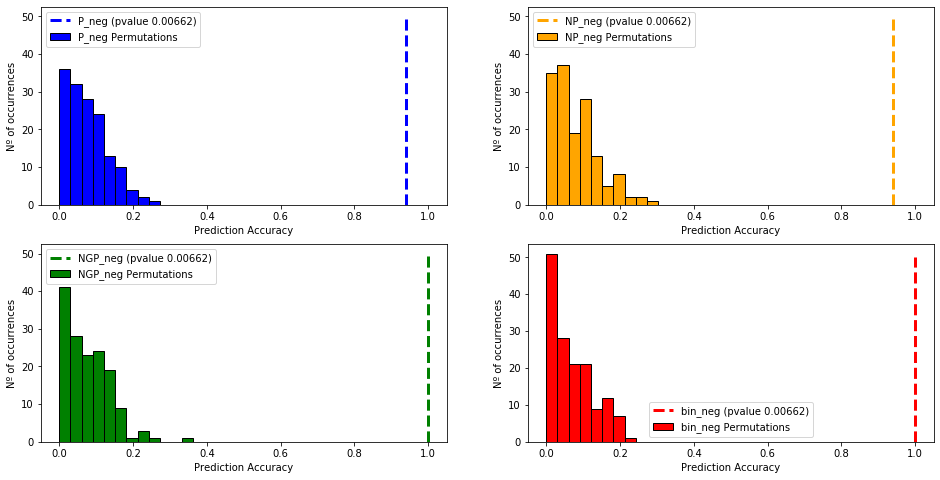

In [143]:
f, axes = plt.subplots(2, 2, figsize = (16,8))

Names = ['P_neg', 'NP_neg', 'NGP_neg', 'bin_neg']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]

n_labels = len(NGP_neg.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs_PLS[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

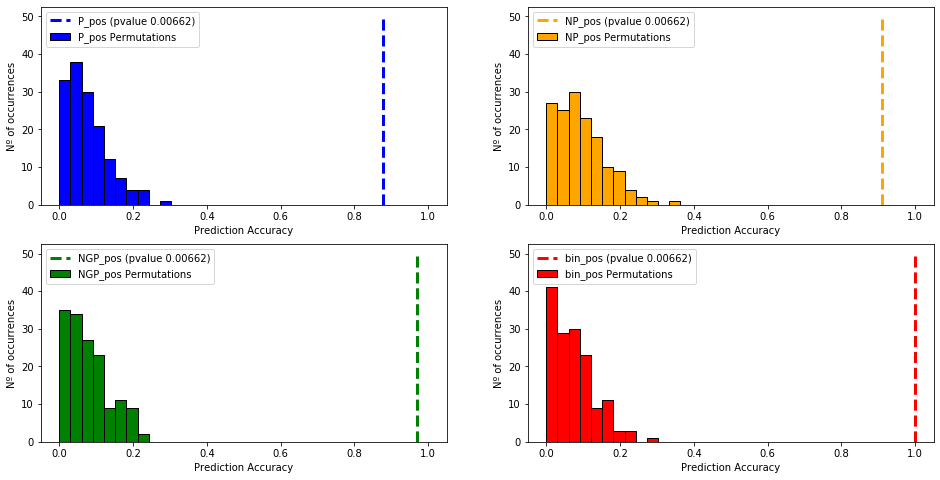

In [144]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_pos', 'NP_pos', 'NGP_pos', 'bin_pos']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]

n_labels = len(NGP_pos.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs_PLS[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

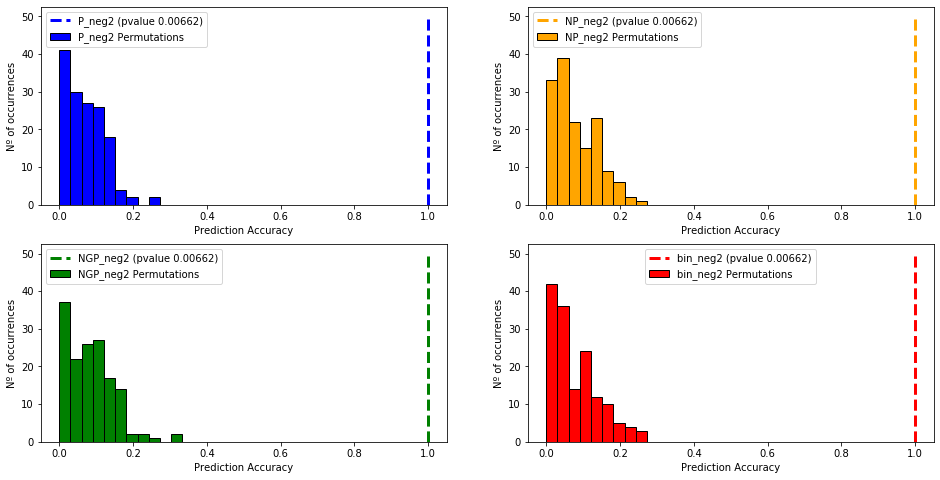

In [145]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_neg2', 'NP_neg2', 'NGP_neg2', 'bin_neg2']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]

n_labels = len(NGP_neg2.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs_PLS[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

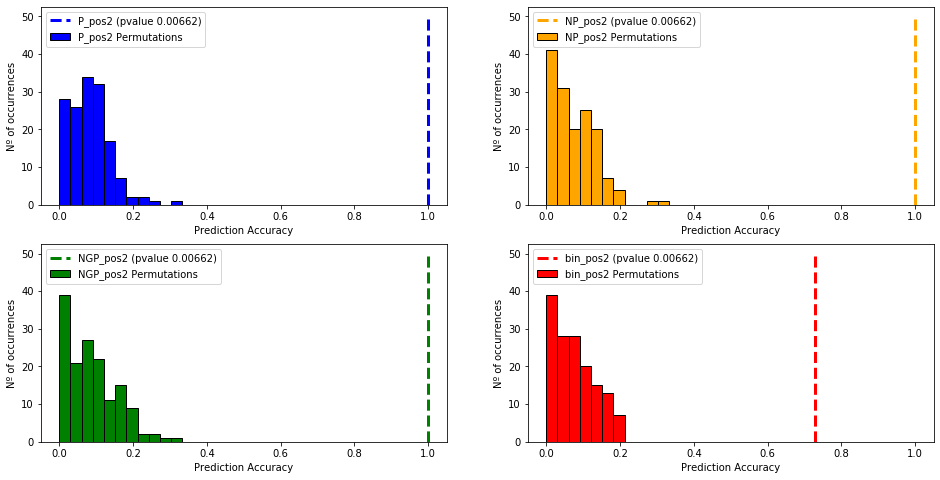

In [146]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_pos2', 'NP_pos2', 'NGP_pos2', 'bin_pos2']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]

n_labels = len(NGP_pos2.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs_PLS[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()